### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 40  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:09<96:29:19, 69.49s/it]

Entrenando:   0%|          | 2/5000 [02:17<95:31:49, 68.81s/it]

Entrenando:   0%|          | 3/5000 [03:41<104:57:45, 75.62s/it]

Entrenando:   0%|          | 4/5000 [05:20<117:45:49, 84.86s/it]

Entrenando:   0%|          | 5/5000 [07:04<127:23:31, 91.81s/it]

Entrenando:   0%|          | 6/5000 [08:50<134:03:33, 96.64s/it]

Entrenando:   0%|          | 7/5000 [10:43<141:22:48, 101.94s/it]

Entrenando:   0%|          | 8/5000 [12:33<145:05:09, 104.63s/it]

Entrenando:   0%|          | 9/5000 [14:18<144:48:14, 104.45s/it]

Entrenando:   0%|          | 10/5000 [16:07<147:07:19, 106.14s/it]

Entrenando:   0%|          | 11/5000 [18:06<152:28:00, 110.02s/it]

Entrenando:   0%|          | 12/5000 [20:51<175:33:05, 126.70s/it]

Entrenando:   0%|          | 13/5000 [23:38<192:27:18, 138.93s/it]

Entrenando:   0%|          | 14/5000 [26:29<205:53:42, 148.66s/it]

Entrenando:   0%|          | 15/5000 [29:14<212:36:00, 153.53s/it]

Entrenando:   0%|          | 16/5000 [32:03<218:51:46, 158.09s/it]

Entrenando:   0%|          | 17/5000 [35:02<227:44:44, 164.54s/it]

Entrenando:   0%|          | 18/5000 [37:41<225:17:23, 162.79s/it]

Entrenando:   0%|          | 19/5000 [40:29<227:29:30, 164.42s/it]

Entrenando:   0%|          | 20/5000 [44:25<257:06:21, 185.86s/it]

Entrenando:   0%|          | 21/5000 [48:19<277:06:03, 200.35s/it]

Entrenando:   0%|          | 22/5000 [52:15<291:39:56, 210.93s/it]

Entrenando:   0%|          | 23/5000 [56:10<301:36:35, 218.16s/it]

Entrenando:   0%|          | 24/5000 [1:00:01<306:45:49, 221.94s/it]

Entrenando:   0%|          | 25/5000 [1:03:57<312:38:20, 226.23s/it]

Entrenando:   1%|          | 26/5000 [1:07:51<315:48:50, 228.57s/it]

Entrenando:   1%|          | 27/5000 [1:11:48<319:14:31, 231.10s/it]

Entrenando:   1%|          | 28/5000 [1:15:31<315:43:12, 228.60s/it]

Entrenando:   1%|          | 29/5000 [1:19:12<312:42:31, 226.46s/it]

Entrenando:   1%|          | 30/5000 [1:22:55<310:56:35, 225.23s/it]

Entrenando:   1%|          | 31/5000 [1:26:38<310:00:32, 224.60s/it]

Entrenando:   1%|          | 32/5000 [1:30:16<307:20:25, 222.71s/it]

Entrenando:   1%|          | 33/5000 [1:33:47<302:15:31, 219.07s/it]

Entrenando:   1%|          | 34/5000 [1:37:15<297:42:34, 215.82s/it]

Entrenando:   1%|          | 35/5000 [1:40:28<288:10:14, 208.95s/it]

Entrenando:   1%|          | 36/5000 [1:43:44<283:01:00, 205.25s/it]

Entrenando:   1%|          | 37/5000 [1:46:35<268:33:09, 194.80s/it]

Entrenando:   1%|          | 38/5000 [1:49:28<259:29:45, 188.27s/it]

Entrenando:   1%|          | 39/5000 [1:52:26<255:17:01, 185.25s/it]

Entrenando:   1%|          | 40/5000 [1:55:18<249:56:29, 181.41s/it]

Entrenando:   1%|          | 41/5000 [1:58:20<250:06:18, 181.56s/it]

Entrenando:   1%|          | 42/5000 [2:01:22<249:59:25, 181.52s/it]

Entrenando:   1%|          | 43/5000 [2:04:04<241:51:57, 175.65s/it]

Entrenando:   1%|          | 44/5000 [2:07:00<242:15:35, 175.98s/it]

Entrenando:   1%|          | 45/5000 [2:10:00<243:43:14, 177.07s/it]

Entrenando:   1%|          | 46/5000 [2:12:54<242:22:03, 176.12s/it]

Entrenando:   1%|          | 47/5000 [2:15:38<237:26:08, 172.58s/it]

Entrenando:   1%|          | 48/5000 [2:18:30<237:08:36, 172.40s/it]

Entrenando:   1%|          | 49/5000 [2:21:02<228:35:55, 166.22s/it]

Entrenando:   1%|          | 50/5000 [2:23:33<222:21:57, 161.72s/it]

Iter  50: train_loss=7.7621, val_loss=7.9966, train_suc=0.669, train_err=0.175, train_inc=0.156 | val_suc=0.651, val_err=0.183, val_inc=0.166


Entrenando:   1%|          | 51/5000 [2:26:06<218:29:22, 158.93s/it]

Entrenando:   1%|          | 52/5000 [2:28:37<215:28:04, 156.77s/it]

Entrenando:   1%|          | 53/5000 [2:31:01<210:02:07, 152.85s/it]

Entrenando:   1%|          | 54/5000 [2:33:20<204:03:17, 148.52s/it]

Entrenando:   1%|          | 55/5000 [2:35:36<198:54:27, 144.81s/it]

Entrenando:   1%|          | 56/5000 [2:37:42<191:18:54, 139.31s/it]

Entrenando:   1%|          | 57/5000 [2:39:48<185:48:55, 135.33s/it]

Entrenando:   1%|          | 58/5000 [2:41:55<182:23:13, 132.86s/it]

Entrenando:   1%|          | 59/5000 [2:43:56<177:24:58, 129.27s/it]

Entrenando:   1%|          | 60/5000 [2:45:40<167:04:21, 121.75s/it]

Entrenando:   1%|          | 61/5000 [2:47:38<165:27:39, 120.60s/it]

Entrenando:   1%|          | 62/5000 [2:49:32<162:23:50, 118.39s/it]

Entrenando:   1%|▏         | 63/5000 [2:51:26<160:55:58, 117.35s/it]

Entrenando:   1%|▏         | 64/5000 [2:53:17<158:02:02, 115.26s/it]

Entrenando:   1%|▏         | 65/5000 [2:55:16<159:43:27, 116.52s/it]

Entrenando:   1%|▏         | 66/5000 [2:57:16<160:54:06, 117.40s/it]

Entrenando:   1%|▏         | 67/5000 [2:59:11<160:10:00, 116.89s/it]

Entrenando:   1%|▏         | 68/5000 [3:01:05<158:51:39, 115.96s/it]

Entrenando:   1%|▏         | 69/5000 [3:02:59<157:45:31, 115.18s/it]

Entrenando:   1%|▏         | 70/5000 [3:04:54<157:53:28, 115.30s/it]

Entrenando:   1%|▏         | 71/5000 [3:06:51<158:34:24, 115.82s/it]

Entrenando:   1%|▏         | 72/5000 [3:08:45<157:43:46, 115.22s/it]

Entrenando:   1%|▏         | 73/5000 [3:10:47<160:25:03, 117.21s/it]

Entrenando:   1%|▏         | 74/5000 [3:12:47<161:42:39, 118.18s/it]

Entrenando:   2%|▏         | 75/5000 [3:14:40<159:14:46, 116.40s/it]

Entrenando:   2%|▏         | 76/5000 [3:16:33<157:53:01, 115.43s/it]

Entrenando:   2%|▏         | 77/5000 [3:18:20<154:39:35, 113.10s/it]

Entrenando:   2%|▏         | 78/5000 [3:20:06<151:21:45, 110.71s/it]

Entrenando:   2%|▏         | 79/5000 [3:22:10<156:46:39, 114.69s/it]

Entrenando:   2%|▏         | 80/5000 [3:24:04<156:33:59, 114.56s/it]

Entrenando:   2%|▏         | 81/5000 [3:25:59<156:50:34, 114.79s/it]

Entrenando:   2%|▏         | 82/5000 [3:27:56<157:33:39, 115.34s/it]

Entrenando:   2%|▏         | 83/5000 [3:29:53<158:16:17, 115.88s/it]

Entrenando:   2%|▏         | 84/5000 [3:31:46<157:03:10, 115.01s/it]

Entrenando:   2%|▏         | 85/5000 [3:33:46<159:08:04, 116.56s/it]

Entrenando:   2%|▏         | 86/5000 [3:35:40<158:14:01, 115.92s/it]

Entrenando:   2%|▏         | 87/5000 [3:37:34<157:18:50, 115.27s/it]

Entrenando:   2%|▏         | 88/5000 [3:39:28<156:47:25, 114.91s/it]

Entrenando:   2%|▏         | 89/5000 [3:41:26<157:54:49, 115.76s/it]

Entrenando:   2%|▏         | 90/5000 [3:43:25<159:06:49, 116.66s/it]

Entrenando:   2%|▏         | 91/5000 [3:45:12<155:22:36, 113.95s/it]

Entrenando:   2%|▏         | 92/5000 [3:47:08<156:11:27, 114.57s/it]

Entrenando:   2%|▏         | 93/5000 [3:49:09<158:42:49, 116.44s/it]

Entrenando:   2%|▏         | 94/5000 [3:51:06<158:37:33, 116.40s/it]

Entrenando:   2%|▏         | 95/5000 [3:53:06<160:23:32, 117.72s/it]

Entrenando:   2%|▏         | 96/5000 [3:55:01<159:17:36, 116.94s/it]

Entrenando:   2%|▏         | 97/5000 [3:57:07<162:42:59, 119.47s/it]

Entrenando:   2%|▏         | 98/5000 [3:59:04<161:38:53, 118.71s/it]

Entrenando:   2%|▏         | 99/5000 [4:01:05<162:40:53, 119.50s/it]

Entrenando:   2%|▏         | 100/5000 [4:02:55<158:48:19, 116.67s/it]

Iter 100: train_loss=3.1944, val_loss=3.4011, train_suc=0.670, train_err=0.060, train_inc=0.270 | val_suc=0.650, val_err=0.062, val_inc=0.288
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:04:58<161:06:57, 118.40s/it]

Entrenando:   2%|▏         | 102/5000 [4:06:51<159:07:39, 116.96s/it]

Entrenando:   2%|▏         | 103/5000 [4:08:49<159:22:21, 117.16s/it]

Entrenando:   2%|▏         | 104/5000 [4:10:47<159:34:25, 117.33s/it]

Entrenando:   2%|▏         | 105/5000 [4:12:35<155:52:45, 114.64s/it]

Entrenando:   2%|▏         | 106/5000 [4:14:33<157:07:53, 115.59s/it]

Entrenando:   2%|▏         | 107/5000 [4:16:24<155:09:13, 114.15s/it]

Entrenando:   2%|▏         | 108/5000 [4:18:25<158:17:01, 116.48s/it]

Entrenando:   2%|▏         | 109/5000 [4:20:18<156:31:03, 115.20s/it]

Entrenando:   2%|▏         | 110/5000 [4:22:08<154:27:34, 113.71s/it]

Entrenando:   2%|▏         | 111/5000 [4:24:03<155:09:12, 114.25s/it]

Entrenando:   2%|▏         | 112/5000 [4:25:55<154:01:42, 113.44s/it]

Entrenando:   2%|▏         | 113/5000 [4:27:52<155:37:12, 114.64s/it]

Entrenando:   2%|▏         | 114/5000 [4:29:48<156:05:25, 115.01s/it]

Entrenando:   2%|▏         | 115/5000 [4:31:39<154:15:06, 113.68s/it]

Entrenando:   2%|▏         | 116/5000 [4:33:30<153:21:31, 113.04s/it]

Entrenando:   2%|▏         | 117/5000 [4:35:24<153:26:20, 113.12s/it]

Entrenando:   2%|▏         | 118/5000 [4:37:13<151:58:11, 112.06s/it]

Entrenando:   2%|▏         | 119/5000 [4:39:02<150:36:20, 111.08s/it]

Entrenando:   2%|▏         | 120/5000 [4:40:47<148:09:07, 109.29s/it]

Entrenando:   2%|▏         | 121/5000 [4:42:44<151:13:11, 111.58s/it]

Entrenando:   2%|▏         | 122/5000 [4:44:36<151:29:28, 111.80s/it]

Entrenando:   2%|▏         | 123/5000 [4:46:29<151:48:01, 112.05s/it]

Entrenando:   2%|▏         | 124/5000 [4:48:26<153:50:39, 113.58s/it]

Entrenando:   2%|▎         | 125/5000 [4:50:13<151:09:38, 111.63s/it]

Entrenando:   3%|▎         | 126/5000 [4:52:05<151:14:20, 111.71s/it]

Entrenando:   3%|▎         | 127/5000 [4:54:06<154:45:26, 114.33s/it]

Entrenando:   3%|▎         | 128/5000 [4:56:03<155:49:11, 115.14s/it]

Entrenando:   3%|▎         | 129/5000 [4:58:13<161:54:11, 119.66s/it]

Entrenando:   3%|▎         | 130/5000 [5:01:39<196:47:19, 145.47s/it]

Entrenando:   3%|▎         | 131/5000 [5:05:18<226:53:34, 167.76s/it]

Entrenando:   3%|▎         | 132/5000 [5:08:50<244:52:22, 181.09s/it]

Entrenando:   3%|▎         | 133/5000 [5:12:21<256:34:03, 189.78s/it]

Entrenando:   3%|▎         | 134/5000 [5:15:55<266:30:38, 197.17s/it]

Entrenando:   3%|▎         | 135/5000 [5:19:33<274:47:06, 203.34s/it]

Entrenando:   3%|▎         | 136/5000 [5:22:56<274:44:02, 203.34s/it]

Entrenando:   3%|▎         | 137/5000 [5:26:16<273:18:18, 202.32s/it]

Entrenando:   3%|▎         | 138/5000 [5:29:40<273:45:56, 202.71s/it]

Entrenando:   3%|▎         | 139/5000 [5:33:07<275:47:53, 204.25s/it]

Entrenando:   3%|▎         | 140/5000 [5:36:39<278:34:12, 206.35s/it]

Entrenando:   3%|▎         | 141/5000 [5:40:14<282:09:45, 209.05s/it]

Entrenando:   3%|▎         | 142/5000 [5:43:43<282:11:46, 209.12s/it]

Entrenando:   3%|▎         | 143/5000 [5:47:14<282:52:16, 209.66s/it]

Entrenando:   3%|▎         | 144/5000 [5:50:44<282:50:00, 209.68s/it]

Entrenando:   3%|▎         | 145/5000 [5:54:13<282:36:34, 209.56s/it]

Entrenando:   3%|▎         | 146/5000 [5:57:51<285:54:36, 212.05s/it]

Entrenando:   3%|▎         | 147/5000 [6:01:24<286:04:41, 212.22s/it]

Entrenando:   3%|▎         | 148/5000 [6:05:02<288:16:32, 213.89s/it]

Entrenando:   3%|▎         | 149/5000 [6:08:34<287:36:45, 213.44s/it]

Entrenando:   3%|▎         | 150/5000 [6:11:56<282:53:21, 209.98s/it]

Iter 150: train_loss=1.0683, val_loss=1.0767, train_suc=0.687, train_err=0.002, train_inc=0.311 | val_suc=0.667, val_err=0.002, val_inc=0.331


Entrenando:   3%|▎         | 151/5000 [6:15:06<274:55:35, 204.11s/it]

Entrenando:   3%|▎         | 152/5000 [6:18:04<264:24:30, 196.34s/it]

Entrenando:   3%|▎         | 153/5000 [6:21:00<255:59:59, 190.14s/it]

Entrenando:   3%|▎         | 154/5000 [6:23:38<242:59:01, 180.51s/it]

Entrenando:   3%|▎         | 155/5000 [6:26:15<233:14:38, 173.31s/it]

Entrenando:   3%|▎         | 156/5000 [6:28:53<227:17:31, 168.92s/it]

Entrenando:   3%|▎         | 157/5000 [6:31:36<224:52:42, 167.16s/it]

Entrenando:   3%|▎         | 158/5000 [6:34:39<231:06:29, 171.83s/it]

Entrenando:   3%|▎         | 159/5000 [6:37:26<229:15:20, 170.49s/it]

Entrenando:   3%|▎         | 160/5000 [6:40:19<230:14:13, 171.25s/it]

Entrenando:   3%|▎         | 161/5000 [6:42:42<218:45:30, 162.75s/it]

Entrenando:   3%|▎         | 162/5000 [6:45:01<208:48:56, 155.38s/it]

Entrenando:   3%|▎         | 163/5000 [6:47:19<201:46:50, 150.18s/it]

Entrenando:   3%|▎         | 164/5000 [6:49:37<196:56:11, 146.60s/it]

Entrenando:   3%|▎         | 165/5000 [6:51:58<194:37:23, 144.91s/it]

Entrenando:   3%|▎         | 166/5000 [6:54:29<196:58:39, 146.69s/it]

Entrenando:   3%|▎         | 167/5000 [6:56:42<191:33:06, 142.68s/it]

Entrenando:   3%|▎         | 168/5000 [6:58:58<188:42:41, 140.60s/it]

Entrenando:   3%|▎         | 169/5000 [7:01:09<185:00:59, 137.87s/it]

Entrenando:   3%|▎         | 170/5000 [7:03:18<181:07:26, 135.00s/it]

Entrenando:   3%|▎         | 171/5000 [7:05:25<177:55:11, 132.64s/it]

Entrenando:   3%|▎         | 172/5000 [7:07:29<174:39:54, 130.24s/it]

Entrenando:   3%|▎         | 173/5000 [7:09:39<174:34:29, 130.20s/it]

Entrenando:   3%|▎         | 174/5000 [7:11:39<170:11:52, 126.96s/it]

Entrenando:   4%|▎         | 175/5000 [7:13:43<169:05:02, 126.16s/it]

Entrenando:   4%|▎         | 176/5000 [7:15:39<164:46:37, 122.97s/it]

Entrenando:   4%|▎         | 177/5000 [7:17:32<161:01:32, 120.19s/it]

Entrenando:   4%|▎         | 178/5000 [7:19:24<157:28:38, 117.57s/it]

Entrenando:   4%|▎         | 179/5000 [7:21:25<158:56:22, 118.69s/it]

Entrenando:   4%|▎         | 180/5000 [7:23:22<158:06:29, 118.09s/it]

Entrenando:   4%|▎         | 181/5000 [7:25:22<159:01:23, 118.80s/it]

Entrenando:   4%|▎         | 182/5000 [7:27:18<157:55:47, 118.00s/it]

Entrenando:   4%|▎         | 183/5000 [7:29:10<155:28:29, 116.19s/it]

Entrenando:   4%|▎         | 184/5000 [7:31:01<153:12:30, 114.52s/it]

Entrenando:   4%|▎         | 185/5000 [7:32:56<153:12:43, 114.55s/it]

Entrenando:   4%|▎         | 186/5000 [7:34:51<153:34:14, 114.84s/it]

Entrenando:   4%|▎         | 187/5000 [7:36:48<154:28:19, 115.54s/it]

Entrenando:   4%|▍         | 188/5000 [7:38:38<152:10:26, 113.85s/it]

Entrenando:   4%|▍         | 189/5000 [7:40:40<155:14:15, 116.16s/it]

Entrenando:   4%|▍         | 190/5000 [7:42:28<152:08:03, 113.86s/it]

Entrenando:   4%|▍         | 191/5000 [7:44:22<152:11:32, 113.93s/it]

Entrenando:   4%|▍         | 192/5000 [7:46:16<151:52:10, 113.71s/it]

Entrenando:   4%|▍         | 193/5000 [7:48:14<153:47:02, 115.17s/it]

Entrenando:   4%|▍         | 194/5000 [7:50:15<156:02:43, 116.89s/it]

Entrenando:   4%|▍         | 195/5000 [7:52:13<156:37:47, 117.35s/it]

Entrenando:   4%|▍         | 196/5000 [7:54:10<156:04:27, 116.96s/it]

Entrenando:   4%|▍         | 197/5000 [7:56:05<155:37:42, 116.65s/it]

Entrenando:   4%|▍         | 198/5000 [7:57:54<152:19:36, 114.20s/it]

Entrenando:   4%|▍         | 199/5000 [7:59:49<152:31:00, 114.36s/it]

Entrenando:   4%|▍         | 200/5000 [8:01:58<158:16:59, 118.71s/it]

Iter 200: train_loss=0.8719, val_loss=0.9243, train_suc=0.711, train_err=0.000, train_inc=0.289 | val_suc=0.693, val_err=0.000, val_inc=0.307
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:03:49<155:20:00, 116.52s/it]

Entrenando:   4%|▍         | 202/5000 [8:05:46<155:27:37, 116.64s/it]

Entrenando:   4%|▍         | 203/5000 [8:07:54<159:59:18, 120.07s/it]

Entrenando:   4%|▍         | 204/5000 [8:09:48<157:21:45, 118.12s/it]

Entrenando:   4%|▍         | 205/5000 [8:11:42<155:55:42, 117.07s/it]

Entrenando:   4%|▍         | 206/5000 [8:13:47<159:12:38, 119.56s/it]

Entrenando:   4%|▍         | 207/5000 [8:15:46<158:41:34, 119.19s/it]

Entrenando:   4%|▍         | 208/5000 [8:17:47<159:29:21, 119.82s/it]

Entrenando:   4%|▍         | 209/5000 [8:19:47<159:30:26, 119.86s/it]

Entrenando:   4%|▍         | 210/5000 [8:21:44<158:31:04, 119.14s/it]

Entrenando:   4%|▍         | 211/5000 [8:23:45<158:51:52, 119.42s/it]

Entrenando:   4%|▍         | 212/5000 [8:25:41<157:28:25, 118.40s/it]

Entrenando:   4%|▍         | 213/5000 [8:27:58<164:53:16, 124.00s/it]

Entrenando:   4%|▍         | 214/5000 [8:31:08<191:13:58, 143.84s/it]

Entrenando:   4%|▍         | 215/5000 [8:34:03<203:46:02, 153.30s/it]

Entrenando:   4%|▍         | 216/5000 [8:36:59<212:41:53, 160.06s/it]

Entrenando:   4%|▍         | 217/5000 [8:40:03<222:21:59, 167.37s/it]

Entrenando:   4%|▍         | 218/5000 [8:43:16<232:14:40, 174.84s/it]

Entrenando:   4%|▍         | 219/5000 [8:46:16<234:24:51, 176.51s/it]

Entrenando:   4%|▍         | 220/5000 [8:49:03<230:42:54, 173.76s/it]

Entrenando:   4%|▍         | 221/5000 [8:52:08<234:51:47, 176.92s/it]

Entrenando:   4%|▍         | 222/5000 [8:55:05<234:58:39, 177.04s/it]

Entrenando:   4%|▍         | 223/5000 [8:57:57<232:57:50, 175.56s/it]

Entrenando:   4%|▍         | 224/5000 [9:00:59<235:20:45, 177.40s/it]

Entrenando:   4%|▍         | 225/5000 [9:03:52<233:33:16, 176.08s/it]

Entrenando:   5%|▍         | 226/5000 [9:06:42<231:14:46, 174.38s/it]

Entrenando:   5%|▍         | 227/5000 [9:09:37<231:08:04, 174.33s/it]

Entrenando:   5%|▍         | 228/5000 [9:12:42<235:39:08, 177.78s/it]

Entrenando:   5%|▍         | 229/5000 [9:15:34<233:13:08, 175.98s/it]

Entrenando:   5%|▍         | 230/5000 [9:18:37<236:02:38, 178.15s/it]

Entrenando:   5%|▍         | 231/5000 [9:21:33<234:56:15, 177.35s/it]

Entrenando:   5%|▍         | 232/5000 [9:24:14<228:37:35, 172.62s/it]

Entrenando:   5%|▍         | 233/5000 [9:27:11<229:58:56, 173.68s/it]

Entrenando:   5%|▍         | 234/5000 [9:30:12<233:05:40, 176.07s/it]

Entrenando:   5%|▍         | 235/5000 [9:33:22<238:40:19, 180.32s/it]

Entrenando:   5%|▍         | 236/5000 [9:36:22<238:14:06, 180.03s/it]

Entrenando:   5%|▍         | 237/5000 [9:39:24<239:11:58, 180.79s/it]

Entrenando:   5%|▍         | 238/5000 [9:42:20<236:58:34, 179.15s/it]

Entrenando:   5%|▍         | 239/5000 [9:45:14<235:04:22, 177.75s/it]

Entrenando:   5%|▍         | 240/5000 [9:48:12<235:12:53, 177.89s/it]

Entrenando:   5%|▍         | 241/5000 [9:51:13<236:16:58, 178.74s/it]

Entrenando:   5%|▍         | 242/5000 [9:54:04<233:18:37, 176.53s/it]

Entrenando:   5%|▍         | 243/5000 [9:57:00<232:51:51, 176.23s/it]

Entrenando:   5%|▍         | 244/5000 [10:00:00<234:18:28, 177.36s/it]

Entrenando:   5%|▍         | 245/5000 [10:02:50<231:18:46, 175.13s/it]

Entrenando:   5%|▍         | 246/5000 [10:05:40<229:24:37, 173.72s/it]

Entrenando:   5%|▍         | 247/5000 [10:08:41<232:01:01, 175.73s/it]

Entrenando:   5%|▍         | 248/5000 [10:11:28<228:26:48, 173.07s/it]

Entrenando:   5%|▍         | 249/5000 [10:14:17<227:05:06, 172.07s/it]

Entrenando:   5%|▌         | 250/5000 [10:17:12<227:53:10, 172.71s/it]

Iter 250: train_loss=0.9250, val_loss=0.8541, train_suc=0.732, train_err=0.000, train_inc=0.268 | val_suc=0.716, val_err=0.000, val_inc=0.284


Entrenando:   5%|▌         | 251/5000 [10:20:11<230:32:44, 174.77s/it]

Entrenando:   5%|▌         | 252/5000 [10:23:13<233:16:38, 176.87s/it]

Entrenando:   5%|▌         | 253/5000 [10:25:51<225:51:42, 171.29s/it]

Entrenando:   5%|▌         | 254/5000 [10:28:30<221:00:56, 167.65s/it]

Entrenando:   5%|▌         | 255/5000 [10:31:22<222:24:37, 168.74s/it]

Entrenando:   5%|▌         | 256/5000 [10:34:18<225:21:46, 171.02s/it]

Entrenando:   5%|▌         | 257/5000 [10:37:12<226:36:34, 172.00s/it]

Entrenando:   5%|▌         | 258/5000 [10:40:17<231:24:51, 175.68s/it]

Entrenando:   5%|▌         | 259/5000 [10:43:01<226:47:14, 172.21s/it]

Entrenando:   5%|▌         | 260/5000 [10:45:51<226:01:38, 171.67s/it]

Entrenando:   5%|▌         | 261/5000 [10:49:02<233:45:51, 177.58s/it]

Entrenando:   5%|▌         | 262/5000 [10:52:08<236:56:12, 180.03s/it]

Entrenando:   5%|▌         | 263/5000 [10:55:14<239:20:47, 181.90s/it]

Entrenando:   5%|▌         | 264/5000 [10:58:04<234:28:04, 178.23s/it]

Entrenando:   5%|▌         | 265/5000 [11:01:13<238:47:05, 181.55s/it]

Entrenando:   5%|▌         | 266/5000 [11:04:10<236:43:31, 180.02s/it]

Entrenando:   5%|▌         | 267/5000 [11:07:16<239:10:39, 181.92s/it]

Entrenando:   5%|▌         | 268/5000 [11:10:13<237:15:47, 180.50s/it]

Entrenando:   5%|▌         | 269/5000 [11:13:06<234:11:23, 178.20s/it]

Entrenando:   5%|▌         | 270/5000 [11:15:52<229:05:47, 174.37s/it]

Entrenando:   5%|▌         | 271/5000 [11:18:41<227:13:32, 172.98s/it]

Entrenando:   5%|▌         | 272/5000 [11:21:37<228:10:34, 173.74s/it]

Entrenando:   5%|▌         | 273/5000 [11:24:39<231:16:03, 176.13s/it]

Entrenando:   5%|▌         | 274/5000 [11:27:29<228:51:12, 174.33s/it]

Entrenando:   6%|▌         | 275/5000 [11:30:27<230:16:39, 175.45s/it]

Entrenando:   6%|▌         | 276/5000 [11:33:14<226:55:57, 172.94s/it]

Entrenando:   6%|▌         | 277/5000 [11:36:11<228:44:13, 174.35s/it]

Entrenando:   6%|▌         | 278/5000 [11:39:00<226:11:47, 172.45s/it]

Entrenando:   6%|▌         | 279/5000 [11:42:01<229:33:01, 175.04s/it]

Entrenando:   6%|▌         | 280/5000 [11:44:59<230:38:50, 175.92s/it]

Entrenando:   6%|▌         | 281/5000 [11:47:59<232:15:08, 177.18s/it]

Entrenando:   6%|▌         | 282/5000 [11:50:47<228:48:09, 174.58s/it]

Entrenando:   6%|▌         | 283/5000 [11:53:37<226:54:06, 173.17s/it]

Entrenando:   6%|▌         | 284/5000 [11:56:32<227:32:13, 173.69s/it]

Entrenando:   6%|▌         | 285/5000 [11:59:44<234:31:36, 179.07s/it]

Entrenando:   6%|▌         | 286/5000 [12:02:46<235:53:03, 180.14s/it]

Entrenando:   6%|▌         | 287/5000 [12:05:41<233:37:22, 178.45s/it]

Entrenando:   6%|▌         | 288/5000 [12:08:45<235:43:43, 180.10s/it]

Entrenando:   6%|▌         | 289/5000 [12:11:33<231:08:46, 176.63s/it]

Entrenando:   6%|▌         | 290/5000 [12:14:19<226:49:27, 173.37s/it]

Entrenando:   6%|▌         | 291/5000 [12:17:18<229:06:46, 175.16s/it]

Entrenando:   6%|▌         | 292/5000 [12:20:23<232:38:03, 177.89s/it]

Entrenando:   6%|▌         | 293/5000 [12:23:17<231:14:03, 176.85s/it]

Entrenando:   6%|▌         | 294/5000 [12:26:32<238:23:24, 182.36s/it]

Entrenando:   6%|▌         | 295/5000 [12:29:22<233:20:04, 178.53s/it]

Entrenando:   6%|▌         | 296/5000 [12:32:13<230:29:12, 176.39s/it]

Entrenando:   6%|▌         | 297/5000 [12:35:08<229:56:58, 176.02s/it]

Entrenando:   6%|▌         | 298/5000 [12:38:13<233:22:58, 178.69s/it]

Entrenando:   6%|▌         | 299/5000 [12:41:04<230:21:51, 176.41s/it]

Entrenando:   6%|▌         | 300/5000 [12:44:03<231:17:34, 177.16s/it]

Iter 300: train_loss=0.8874, val_loss=0.7993, train_suc=0.749, train_err=0.000, train_inc=0.251 | val_suc=0.734, val_err=0.000, val_inc=0.266
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:47:05<232:50:22, 178.38s/it]

Entrenando:   6%|▌         | 302/5000 [12:50:05<233:31:38, 178.95s/it]

Entrenando:   6%|▌         | 303/5000 [12:52:56<230:25:52, 176.61s/it]

Entrenando:   6%|▌         | 304/5000 [12:55:45<227:27:12, 174.37s/it]

Entrenando:   6%|▌         | 305/5000 [12:58:45<229:25:18, 175.91s/it]

Entrenando:   6%|▌         | 306/5000 [13:01:31<225:35:26, 173.01s/it]

Entrenando:   6%|▌         | 307/5000 [13:04:27<226:45:09, 173.94s/it]

Entrenando:   6%|▌         | 308/5000 [13:07:09<222:13:11, 170.50s/it]

Entrenando:   6%|▌         | 309/5000 [13:10:05<224:09:31, 172.03s/it]

Entrenando:   6%|▌         | 310/5000 [13:13:02<226:03:45, 173.52s/it]

Entrenando:   6%|▌         | 311/5000 [13:15:58<226:47:46, 174.12s/it]

Entrenando:   6%|▌         | 312/5000 [13:18:53<227:07:17, 174.41s/it]

Entrenando:   6%|▋         | 313/5000 [13:21:44<225:52:32, 173.49s/it]

Entrenando:   6%|▋         | 314/5000 [13:24:47<229:39:55, 176.44s/it]

Entrenando:   6%|▋         | 315/5000 [13:27:39<227:55:03, 175.13s/it]

Entrenando:   6%|▋         | 316/5000 [13:30:49<233:40:05, 179.59s/it]

Entrenando:   6%|▋         | 317/5000 [13:33:47<232:52:13, 179.02s/it]

Entrenando:   6%|▋         | 318/5000 [13:36:44<231:51:21, 178.27s/it]

Entrenando:   6%|▋         | 319/5000 [13:39:41<231:20:10, 177.91s/it]

Entrenando:   6%|▋         | 320/5000 [13:42:37<230:42:43, 177.47s/it]

Entrenando:   6%|▋         | 321/5000 [13:45:39<232:28:15, 178.86s/it]

Entrenando:   6%|▋         | 322/5000 [13:48:39<232:36:35, 179.01s/it]

Entrenando:   6%|▋         | 323/5000 [13:51:40<233:21:24, 179.62s/it]

Entrenando:   6%|▋         | 324/5000 [13:54:39<233:07:50, 179.48s/it]

Entrenando:   6%|▋         | 325/5000 [13:57:28<228:56:42, 176.30s/it]

Entrenando:   7%|▋         | 326/5000 [14:00:48<238:26:09, 183.65s/it]

Entrenando:   7%|▋         | 327/5000 [14:03:47<236:22:55, 182.10s/it]

Entrenando:   7%|▋         | 328/5000 [14:06:50<236:38:08, 182.34s/it]

Entrenando:   7%|▋         | 329/5000 [14:10:00<239:45:24, 184.78s/it]

Entrenando:   7%|▋         | 330/5000 [14:13:07<240:20:50, 185.28s/it]

Entrenando:   7%|▋         | 331/5000 [14:15:49<231:18:16, 178.35s/it]

Entrenando:   7%|▋         | 332/5000 [14:18:36<226:40:15, 174.81s/it]

Entrenando:   7%|▋         | 333/5000 [14:21:29<226:13:45, 174.51s/it]

Entrenando:   7%|▋         | 334/5000 [14:24:26<226:50:41, 175.02s/it]

Entrenando:   7%|▋         | 335/5000 [14:27:29<230:11:35, 177.64s/it]

Entrenando:   7%|▋         | 336/5000 [14:30:22<228:09:38, 176.11s/it]

Entrenando:   7%|▋         | 337/5000 [14:33:15<226:54:11, 175.18s/it]

Entrenando:   7%|▋         | 338/5000 [14:36:04<224:23:10, 173.27s/it]

Entrenando:   7%|▋         | 339/5000 [14:39:04<226:59:53, 175.33s/it]

Entrenando:   7%|▋         | 340/5000 [14:42:04<228:58:50, 176.89s/it]

Entrenando:   7%|▋         | 341/5000 [14:44:52<225:24:29, 174.17s/it]

Entrenando:   7%|▋         | 342/5000 [14:47:45<224:54:19, 173.82s/it]

Entrenando:   7%|▋         | 343/5000 [14:50:53<230:27:17, 178.15s/it]

Entrenando:   7%|▋         | 344/5000 [14:53:40<226:06:03, 174.82s/it]

Entrenando:   7%|▋         | 345/5000 [14:56:46<230:12:23, 178.03s/it]

Entrenando:   7%|▋         | 346/5000 [14:59:36<226:56:00, 175.54s/it]

Entrenando:   7%|▋         | 347/5000 [15:02:38<229:23:47, 177.48s/it]

Entrenando:   7%|▋         | 348/5000 [15:05:35<229:17:07, 177.44s/it]

Entrenando:   7%|▋         | 349/5000 [15:08:48<235:14:58, 182.09s/it]

Entrenando:   7%|▋         | 350/5000 [15:11:42<232:07:57, 179.72s/it]

Iter 350: train_loss=0.7246, val_loss=0.7665, train_suc=0.759, train_err=0.000, train_inc=0.241 | val_suc=0.745, val_err=0.000, val_inc=0.255


Entrenando:   7%|▋         | 351/5000 [15:14:52<235:49:57, 182.62s/it]

Entrenando:   7%|▋         | 352/5000 [15:17:44<231:54:52, 179.62s/it]

Entrenando:   7%|▋         | 353/5000 [15:20:52<235:03:35, 182.10s/it]

Entrenando:   7%|▋         | 354/5000 [15:23:43<230:33:40, 178.65s/it]

Entrenando:   7%|▋         | 355/5000 [15:26:41<230:29:57, 178.64s/it]

Entrenando:   7%|▋         | 356/5000 [15:29:34<228:05:02, 176.81s/it]

Entrenando:   7%|▋         | 357/5000 [15:32:43<232:52:33, 180.56s/it]

Entrenando:   7%|▋         | 358/5000 [15:35:41<231:53:51, 179.84s/it]

Entrenando:   7%|▋         | 359/5000 [15:38:39<230:57:16, 179.15s/it]

Entrenando:   7%|▋         | 360/5000 [15:41:35<229:35:48, 178.14s/it]

Entrenando:   7%|▋         | 361/5000 [15:44:41<232:46:25, 180.64s/it]

Entrenando:   7%|▋         | 362/5000 [15:47:32<228:48:14, 177.60s/it]

Entrenando:   7%|▋         | 363/5000 [15:50:30<229:08:05, 177.89s/it]

Entrenando:   7%|▋         | 364/5000 [15:53:20<225:55:14, 175.43s/it]

Entrenando:   7%|▋         | 365/5000 [15:56:22<228:15:54, 177.29s/it]

Entrenando:   7%|▋         | 366/5000 [15:59:36<234:49:53, 182.43s/it]

Entrenando:   7%|▋         | 367/5000 [16:02:30<231:37:23, 179.98s/it]

Entrenando:   7%|▋         | 368/5000 [16:05:23<228:37:34, 177.69s/it]

Entrenando:   7%|▋         | 369/5000 [16:08:19<228:10:27, 177.38s/it]

Entrenando:   7%|▋         | 370/5000 [16:11:13<226:44:36, 176.30s/it]

Entrenando:   7%|▋         | 371/5000 [16:14:07<225:55:00, 175.70s/it]

Entrenando:   7%|▋         | 372/5000 [16:16:59<224:24:41, 174.56s/it]

Entrenando:   7%|▋         | 373/5000 [16:20:08<229:56:36, 178.91s/it]

Entrenando:   7%|▋         | 374/5000 [16:23:14<232:28:33, 180.92s/it]

Entrenando:   8%|▊         | 375/5000 [16:26:17<233:27:34, 181.72s/it]

Entrenando:   8%|▊         | 376/5000 [16:29:19<233:13:16, 181.57s/it]

Entrenando:   8%|▊         | 377/5000 [16:32:17<232:07:07, 180.75s/it]

Entrenando:   8%|▊         | 378/5000 [16:35:18<232:03:24, 180.75s/it]

Entrenando:   8%|▊         | 379/5000 [16:38:26<234:53:56, 183.00s/it]

Entrenando:   8%|▊         | 380/5000 [16:41:10<227:29:20, 177.26s/it]

Entrenando:   8%|▊         | 381/5000 [16:44:12<229:08:23, 178.59s/it]

Entrenando:   8%|▊         | 382/5000 [16:47:11<229:21:55, 178.80s/it]

Entrenando:   8%|▊         | 383/5000 [16:50:11<229:36:40, 179.03s/it]

Entrenando:   8%|▊         | 384/5000 [16:53:10<229:34:52, 179.05s/it]

Entrenando:   8%|▊         | 385/5000 [16:56:10<229:56:47, 179.37s/it]

Entrenando:   8%|▊         | 386/5000 [16:59:11<230:38:31, 179.95s/it]

Entrenando:   8%|▊         | 387/5000 [17:02:03<227:31:51, 177.57s/it]

Entrenando:   8%|▊         | 388/5000 [17:05:10<231:07:43, 180.41s/it]

Entrenando:   8%|▊         | 389/5000 [17:08:06<229:01:52, 178.81s/it]

Entrenando:   8%|▊         | 390/5000 [17:11:03<228:32:21, 178.47s/it]

Entrenando:   8%|▊         | 391/5000 [17:14:12<232:18:58, 181.46s/it]

Entrenando:   8%|▊         | 392/5000 [17:17:16<233:20:47, 182.30s/it]

Entrenando:   8%|▊         | 393/5000 [17:20:06<228:33:14, 178.60s/it]

Entrenando:   8%|▊         | 394/5000 [17:23:03<228:04:18, 178.26s/it]

Entrenando:   8%|▊         | 395/5000 [17:25:51<223:59:53, 175.11s/it]

Entrenando:   8%|▊         | 396/5000 [17:28:55<227:25:54, 177.84s/it]

Entrenando:   8%|▊         | 397/5000 [17:31:49<225:51:49, 176.65s/it]

Entrenando:   8%|▊         | 398/5000 [17:34:40<223:33:54, 174.89s/it]

Entrenando:   8%|▊         | 399/5000 [17:37:42<226:22:55, 177.13s/it]

Entrenando:   8%|▊         | 400/5000 [17:40:45<228:23:18, 178.74s/it]

Iter 400: train_loss=0.7321, val_loss=0.7529, train_suc=0.763, train_err=0.000, train_inc=0.237 | val_suc=0.750, val_err=0.000, val_inc=0.250
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [17:43:43<228:09:18, 178.59s/it]

Entrenando:   8%|▊         | 402/5000 [17:46:51<231:50:22, 181.52s/it]

Entrenando:   8%|▊         | 403/5000 [17:50:02<235:18:22, 184.27s/it]

Entrenando:   8%|▊         | 404/5000 [17:53:05<234:32:03, 183.71s/it]

Entrenando:   8%|▊         | 405/5000 [17:55:58<230:42:16, 180.75s/it]

Entrenando:   8%|▊         | 406/5000 [17:58:49<226:58:07, 177.86s/it]

Entrenando:   8%|▊         | 407/5000 [18:01:40<224:08:13, 175.68s/it]

Entrenando:   8%|▊         | 408/5000 [18:04:37<224:35:48, 176.08s/it]

Entrenando:   8%|▊         | 409/5000 [18:07:32<224:16:59, 175.87s/it]

Entrenando:   8%|▊         | 410/5000 [18:10:20<220:56:54, 173.29s/it]

Entrenando:   8%|▊         | 411/5000 [18:13:36<229:32:10, 180.07s/it]

Entrenando:   8%|▊         | 412/5000 [18:16:47<233:57:05, 183.57s/it]

Entrenando:   8%|▊         | 413/5000 [18:19:52<234:21:57, 183.94s/it]

Entrenando:   8%|▊         | 414/5000 [18:22:55<233:52:10, 183.59s/it]

Entrenando:   8%|▊         | 415/5000 [18:25:51<230:52:59, 181.28s/it]

Entrenando:   8%|▊         | 416/5000 [18:28:37<224:52:32, 176.60s/it]

Entrenando:   8%|▊         | 417/5000 [18:31:45<229:31:20, 180.29s/it]

Entrenando:   8%|▊         | 418/5000 [18:34:41<227:30:17, 178.75s/it]

Entrenando:   8%|▊         | 419/5000 [18:37:39<227:30:39, 178.79s/it]

Entrenando:   8%|▊         | 420/5000 [18:40:40<228:04:55, 179.28s/it]

Entrenando:   8%|▊         | 421/5000 [18:43:36<226:58:54, 178.45s/it]

Entrenando:   8%|▊         | 422/5000 [18:46:31<225:35:58, 177.40s/it]

Entrenando:   8%|▊         | 423/5000 [18:49:38<229:00:42, 180.13s/it]

Entrenando:   8%|▊         | 424/5000 [18:52:36<228:12:10, 179.53s/it]

Entrenando:   8%|▊         | 425/5000 [18:55:33<227:01:46, 178.65s/it]

Entrenando:   9%|▊         | 426/5000 [18:58:31<226:43:07, 178.44s/it]

Entrenando:   9%|▊         | 427/5000 [19:01:24<224:38:39, 176.85s/it]

Entrenando:   9%|▊         | 428/5000 [19:04:18<223:37:36, 176.08s/it]

Entrenando:   9%|▊         | 429/5000 [19:07:23<226:50:02, 178.65s/it]

Entrenando:   9%|▊         | 430/5000 [19:10:06<220:57:09, 174.05s/it]

Entrenando:   9%|▊         | 431/5000 [19:13:16<227:12:04, 179.02s/it]

Entrenando:   9%|▊         | 432/5000 [19:16:21<229:15:22, 180.67s/it]

Entrenando:   9%|▊         | 433/5000 [19:19:24<229:58:10, 181.28s/it]

Entrenando:   9%|▊         | 434/5000 [19:22:21<228:12:33, 179.93s/it]

Entrenando:   9%|▊         | 435/5000 [19:25:29<231:17:14, 182.40s/it]

Entrenando:   9%|▊         | 436/5000 [19:28:29<230:31:25, 181.83s/it]

Entrenando:   9%|▊         | 437/5000 [19:31:24<227:59:20, 179.87s/it]

Entrenando:   9%|▉         | 438/5000 [19:34:22<226:59:02, 179.12s/it]

Entrenando:   9%|▉         | 439/5000 [19:37:26<228:52:25, 180.65s/it]

Entrenando:   9%|▉         | 440/5000 [19:40:24<227:40:21, 179.74s/it]

Entrenando:   9%|▉         | 441/5000 [19:43:17<225:13:36, 177.85s/it]

Entrenando:   9%|▉         | 442/5000 [19:46:15<225:17:55, 177.95s/it]

Entrenando:   9%|▉         | 443/5000 [19:49:04<221:47:15, 175.21s/it]

Entrenando:   9%|▉         | 444/5000 [19:51:51<218:33:45, 172.70s/it]

Entrenando:   9%|▉         | 445/5000 [19:54:34<214:55:53, 169.87s/it]

Entrenando:   9%|▉         | 446/5000 [19:57:23<214:38:58, 169.68s/it]

Entrenando:   9%|▉         | 447/5000 [20:00:17<215:52:35, 170.69s/it]

Entrenando:   9%|▉         | 448/5000 [20:03:29<224:07:41, 177.25s/it]

Entrenando:   9%|▉         | 449/5000 [20:06:40<229:22:39, 181.45s/it]

Entrenando:   9%|▉         | 450/5000 [20:09:41<228:59:27, 181.18s/it]

Iter 450: train_loss=0.6675, val_loss=0.7491, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:   9%|▉         | 451/5000 [20:12:35<226:24:07, 179.17s/it]

Entrenando:   9%|▉         | 452/5000 [20:15:32<225:25:42, 178.44s/it]

Entrenando:   9%|▉         | 453/5000 [20:18:33<226:08:58, 179.05s/it]

Entrenando:   9%|▉         | 454/5000 [20:21:35<227:27:26, 180.12s/it]

Entrenando:   9%|▉         | 455/5000 [20:24:26<223:57:20, 177.39s/it]

Entrenando:   9%|▉         | 456/5000 [20:27:32<227:05:16, 179.91s/it]

Entrenando:   9%|▉         | 457/5000 [20:30:34<227:44:36, 180.47s/it]

Entrenando:   9%|▉         | 458/5000 [20:33:22<222:59:16, 176.74s/it]

Entrenando:   9%|▉         | 459/5000 [20:36:19<223:16:21, 177.01s/it]

Entrenando:   9%|▉         | 460/5000 [20:39:12<221:28:36, 175.62s/it]

Entrenando:   9%|▉         | 461/5000 [20:42:06<220:50:07, 175.15s/it]

Entrenando:   9%|▉         | 462/5000 [20:45:01<220:50:20, 175.19s/it]

Entrenando:   9%|▉         | 463/5000 [20:47:46<216:47:34, 172.02s/it]

Entrenando:   9%|▉         | 464/5000 [20:50:55<223:09:17, 177.11s/it]

Entrenando:   9%|▉         | 465/5000 [20:53:47<221:05:34, 175.51s/it]

Entrenando:   9%|▉         | 466/5000 [20:57:05<229:46:10, 182.44s/it]

Entrenando:   9%|▉         | 467/5000 [21:00:03<227:49:28, 180.93s/it]

Entrenando:   9%|▉         | 468/5000 [21:02:59<226:08:52, 179.64s/it]

Entrenando:   9%|▉         | 469/5000 [21:06:03<227:42:05, 180.92s/it]

Entrenando:   9%|▉         | 470/5000 [21:08:54<223:50:24, 177.89s/it]

Entrenando:   9%|▉         | 471/5000 [21:11:55<224:58:12, 178.82s/it]

Entrenando:   9%|▉         | 472/5000 [21:14:45<221:28:35, 176.09s/it]

Entrenando:   9%|▉         | 473/5000 [21:17:45<223:01:53, 177.36s/it]

Entrenando:   9%|▉         | 474/5000 [21:20:43<223:12:31, 177.54s/it]

Entrenando:  10%|▉         | 475/5000 [21:23:36<221:28:44, 176.20s/it]

Entrenando:  10%|▉         | 476/5000 [21:26:29<220:02:18, 175.10s/it]

Entrenando:  10%|▉         | 477/5000 [21:29:20<218:48:05, 174.15s/it]

Entrenando:  10%|▉         | 478/5000 [21:32:07<215:58:47, 171.94s/it]

Entrenando:  10%|▉         | 479/5000 [21:35:01<216:33:47, 172.45s/it]

Entrenando:  10%|▉         | 480/5000 [21:38:01<219:16:57, 174.65s/it]

Entrenando:  10%|▉         | 481/5000 [21:40:49<216:48:15, 172.71s/it]

Entrenando:  10%|▉         | 482/5000 [21:43:37<215:01:07, 171.33s/it]

Entrenando:  10%|▉         | 483/5000 [21:46:32<216:33:30, 172.59s/it]

Entrenando:  10%|▉         | 484/5000 [21:49:32<218:57:58, 174.55s/it]

Entrenando:  10%|▉         | 485/5000 [21:52:39<223:39:59, 178.34s/it]

Entrenando:  10%|▉         | 486/5000 [21:55:33<222:11:01, 177.20s/it]

Entrenando:  10%|▉         | 487/5000 [21:58:26<220:36:58, 175.98s/it]

Entrenando:  10%|▉         | 488/5000 [22:01:21<220:11:05, 175.68s/it]

Entrenando:  10%|▉         | 489/5000 [22:04:22<221:52:25, 177.07s/it]

Entrenando:  10%|▉         | 490/5000 [22:07:25<224:14:02, 178.99s/it]

Entrenando:  10%|▉         | 491/5000 [22:10:35<228:11:30, 182.19s/it]

Entrenando:  10%|▉         | 492/5000 [22:13:22<222:35:06, 177.75s/it]

Entrenando:  10%|▉         | 493/5000 [22:16:09<218:33:02, 174.57s/it]

Entrenando:  10%|▉         | 494/5000 [22:18:52<214:06:53, 171.06s/it]

Entrenando:  10%|▉         | 495/5000 [22:21:41<213:00:04, 170.21s/it]

Entrenando:  10%|▉         | 496/5000 [22:24:25<210:45:47, 168.46s/it]

Entrenando:  10%|▉         | 497/5000 [22:27:12<210:10:00, 168.02s/it]

Entrenando:  10%|▉         | 498/5000 [22:30:02<211:03:11, 168.77s/it]

Entrenando:  10%|▉         | 499/5000 [22:32:58<213:36:58, 170.86s/it]

Entrenando:  10%|█         | 500/5000 [22:35:41<210:35:25, 168.47s/it]

Iter 500: train_loss=0.6971, val_loss=0.7482, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.248
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [22:38:18<206:18:12, 165.08s/it]

Entrenando:  10%|█         | 502/5000 [22:40:55<203:09:42, 162.60s/it]

Entrenando:  10%|█         | 503/5000 [22:43:43<205:05:31, 164.18s/it]

Entrenando:  10%|█         | 504/5000 [22:46:38<209:08:55, 167.47s/it]

Entrenando:  10%|█         | 505/5000 [22:49:19<206:35:33, 165.46s/it]

Entrenando:  10%|█         | 506/5000 [22:51:51<201:31:39, 161.44s/it]

Entrenando:  10%|█         | 507/5000 [22:54:25<198:50:47, 159.33s/it]

Entrenando:  10%|█         | 508/5000 [22:56:59<196:37:05, 157.57s/it]

Entrenando:  10%|█         | 509/5000 [22:59:33<195:27:09, 156.68s/it]

Entrenando:  10%|█         | 510/5000 [23:02:06<193:43:49, 155.33s/it]

Entrenando:  10%|█         | 511/5000 [23:04:38<192:44:25, 154.57s/it]

Entrenando:  10%|█         | 512/5000 [23:07:11<192:03:28, 154.06s/it]

Entrenando:  10%|█         | 513/5000 [23:09:46<192:29:06, 154.43s/it]

Entrenando:  10%|█         | 514/5000 [23:12:20<192:08:43, 154.20s/it]

Entrenando:  10%|█         | 515/5000 [23:14:56<192:53:50, 154.83s/it]

Entrenando:  10%|█         | 516/5000 [23:17:30<192:13:10, 154.32s/it]

Entrenando:  10%|█         | 517/5000 [23:20:04<192:02:08, 154.21s/it]

Entrenando:  10%|█         | 518/5000 [23:22:36<191:18:13, 153.66s/it]

Entrenando:  10%|█         | 519/5000 [23:25:07<190:13:20, 152.82s/it]

Entrenando:  10%|█         | 520/5000 [23:27:39<190:05:26, 152.75s/it]

Entrenando:  10%|█         | 521/5000 [23:30:11<189:36:47, 152.40s/it]

Entrenando:  10%|█         | 522/5000 [23:32:43<189:15:51, 152.16s/it]

Entrenando:  10%|█         | 523/5000 [23:35:17<189:55:37, 152.72s/it]

Entrenando:  10%|█         | 524/5000 [23:37:49<189:50:03, 152.68s/it]

Entrenando:  10%|█         | 525/5000 [23:40:23<190:04:05, 152.90s/it]

Entrenando:  11%|█         | 526/5000 [23:42:53<189:10:34, 152.22s/it]

Entrenando:  11%|█         | 527/5000 [23:45:25<188:56:37, 152.07s/it]

Entrenando:  11%|█         | 528/5000 [23:47:59<189:43:06, 152.72s/it]

Entrenando:  11%|█         | 529/5000 [23:50:29<188:30:51, 151.79s/it]

Entrenando:  11%|█         | 530/5000 [23:52:59<188:01:08, 151.42s/it]

Entrenando:  11%|█         | 531/5000 [23:55:32<188:28:13, 151.82s/it]

Entrenando:  11%|█         | 532/5000 [23:58:05<188:44:51, 152.08s/it]

Entrenando:  11%|█         | 533/5000 [24:00:35<188:06:35, 151.60s/it]

Entrenando:  11%|█         | 534/5000 [24:03:08<188:20:51, 151.83s/it]

Entrenando:  11%|█         | 535/5000 [24:05:41<188:56:32, 152.34s/it]

Entrenando:  11%|█         | 536/5000 [24:08:12<188:13:16, 151.79s/it]

Entrenando:  11%|█         | 537/5000 [24:10:43<188:08:18, 151.76s/it]

Entrenando:  11%|█         | 538/5000 [24:13:19<189:25:59, 152.84s/it]

Entrenando:  11%|█         | 539/5000 [24:15:52<189:22:58, 152.83s/it]

Entrenando:  11%|█         | 540/5000 [24:18:24<189:12:16, 152.72s/it]

Entrenando:  11%|█         | 541/5000 [24:20:56<188:47:27, 152.42s/it]

Entrenando:  11%|█         | 542/5000 [24:23:28<188:39:52, 152.35s/it]

Entrenando:  11%|█         | 543/5000 [24:25:59<188:01:48, 151.88s/it]

Entrenando:  11%|█         | 544/5000 [24:28:30<187:53:35, 151.80s/it]

Entrenando:  11%|█         | 545/5000 [24:31:02<187:59:26, 151.91s/it]

Entrenando:  11%|█         | 546/5000 [24:33:33<187:37:17, 151.65s/it]

Entrenando:  11%|█         | 547/5000 [24:35:57<184:37:03, 149.25s/it]

Entrenando:  11%|█         | 548/5000 [24:38:23<183:12:17, 148.14s/it]

Entrenando:  11%|█         | 549/5000 [24:40:54<184:28:23, 149.20s/it]

Entrenando:  11%|█         | 550/5000 [24:43:28<186:02:54, 150.51s/it]

Iter 550: train_loss=0.6011, val_loss=0.7485, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  11%|█         | 551/5000 [24:46:02<187:10:50, 151.46s/it]

Entrenando:  11%|█         | 552/5000 [24:48:35<187:41:04, 151.90s/it]

Entrenando:  11%|█         | 553/5000 [24:51:08<188:05:56, 152.27s/it]

Entrenando:  11%|█         | 554/5000 [24:53:40<188:01:31, 152.25s/it]

Entrenando:  11%|█         | 555/5000 [24:56:11<187:27:58, 151.83s/it]

Entrenando:  11%|█         | 556/5000 [24:58:44<187:46:22, 152.11s/it]

Entrenando:  11%|█         | 557/5000 [25:01:19<188:54:24, 153.06s/it]

Entrenando:  11%|█         | 558/5000 [25:03:49<187:41:35, 152.12s/it]

Entrenando:  11%|█         | 559/5000 [25:06:22<188:09:20, 152.52s/it]

Entrenando:  11%|█         | 560/5000 [25:08:54<188:00:00, 152.43s/it]

Entrenando:  11%|█         | 561/5000 [25:11:26<187:41:48, 152.22s/it]

Entrenando:  11%|█         | 562/5000 [25:13:58<187:36:37, 152.19s/it]

Entrenando:  11%|█▏        | 563/5000 [25:16:32<188:16:59, 152.77s/it]

Entrenando:  11%|█▏        | 564/5000 [25:19:06<188:30:46, 152.99s/it]

Entrenando:  11%|█▏        | 565/5000 [25:21:39<188:40:12, 153.15s/it]

Entrenando:  11%|█▏        | 566/5000 [25:24:12<188:23:42, 152.96s/it]

Entrenando:  11%|█▏        | 567/5000 [25:26:45<188:24:54, 153.01s/it]

Entrenando:  11%|█▏        | 568/5000 [25:29:18<188:15:50, 152.92s/it]

Entrenando:  11%|█▏        | 569/5000 [25:31:52<188:37:31, 153.25s/it]

Entrenando:  11%|█▏        | 570/5000 [25:34:21<187:15:11, 152.17s/it]

Entrenando:  11%|█▏        | 571/5000 [25:36:51<186:15:32, 151.40s/it]

Entrenando:  11%|█▏        | 572/5000 [25:39:26<187:25:23, 152.38s/it]

Entrenando:  11%|█▏        | 573/5000 [25:41:59<187:49:01, 152.73s/it]

Entrenando:  11%|█▏        | 574/5000 [25:44:31<187:18:51, 152.36s/it]

Entrenando:  12%|█▏        | 575/5000 [25:47:04<187:41:04, 152.69s/it]

Entrenando:  12%|█▏        | 576/5000 [25:49:36<187:27:25, 152.54s/it]

Entrenando:  12%|█▏        | 577/5000 [25:52:09<187:21:17, 152.49s/it]

Entrenando:  12%|█▏        | 578/5000 [25:54:40<186:41:49, 151.99s/it]

Entrenando:  12%|█▏        | 579/5000 [25:57:12<186:57:51, 152.24s/it]

Entrenando:  12%|█▏        | 580/5000 [25:59:45<187:04:02, 152.36s/it]

Entrenando:  12%|█▏        | 581/5000 [26:02:16<186:32:45, 151.97s/it]

Entrenando:  12%|█▏        | 582/5000 [26:04:43<184:42:11, 150.51s/it]

Entrenando:  12%|█▏        | 583/5000 [26:07:01<180:03:20, 146.75s/it]

Entrenando:  12%|█▏        | 584/5000 [26:09:19<176:54:17, 144.22s/it]

Entrenando:  12%|█▏        | 585/5000 [26:11:40<175:34:51, 143.17s/it]

Entrenando:  12%|█▏        | 586/5000 [26:13:58<173:41:19, 141.66s/it]

Entrenando:  12%|█▏        | 587/5000 [26:16:16<172:08:41, 140.43s/it]

Entrenando:  12%|█▏        | 588/5000 [26:18:33<171:03:59, 139.58s/it]

Entrenando:  12%|█▏        | 589/5000 [26:20:54<171:11:02, 139.71s/it]

Entrenando:  12%|█▏        | 590/5000 [26:23:12<170:33:13, 139.23s/it]

Entrenando:  12%|█▏        | 591/5000 [26:25:29<169:51:41, 138.69s/it]

Entrenando:  12%|█▏        | 592/5000 [26:27:48<169:49:34, 138.70s/it]

Entrenando:  12%|█▏        | 593/5000 [26:30:05<169:25:08, 138.40s/it]

Entrenando:  12%|█▏        | 594/5000 [26:32:24<169:24:41, 138.42s/it]

Entrenando:  12%|█▏        | 595/5000 [26:34:37<167:20:16, 136.76s/it]

Entrenando:  12%|█▏        | 596/5000 [26:36:46<164:22:53, 134.37s/it]

Entrenando:  12%|█▏        | 597/5000 [26:38:51<161:04:21, 131.70s/it]

Entrenando:  12%|█▏        | 598/5000 [26:40:59<159:34:03, 130.50s/it]

Entrenando:  12%|█▏        | 599/5000 [26:43:07<158:43:21, 129.83s/it]

Entrenando:  12%|█▏        | 600/5000 [26:45:16<158:28:11, 129.66s/it]

Iter 600: train_loss=0.5956, val_loss=0.7483, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [26:47:23<157:21:02, 128.77s/it]

Entrenando:  12%|█▏        | 602/5000 [26:49:33<157:56:02, 129.28s/it]

Entrenando:  12%|█▏        | 603/5000 [26:51:41<157:20:50, 128.83s/it]

Entrenando:  12%|█▏        | 604/5000 [26:53:50<157:26:02, 128.93s/it]

Entrenando:  12%|█▏        | 605/5000 [26:55:59<157:21:01, 128.89s/it]

Entrenando:  12%|█▏        | 606/5000 [26:58:08<157:24:20, 128.96s/it]

Entrenando:  12%|█▏        | 607/5000 [27:00:18<157:28:50, 129.05s/it]

Entrenando:  12%|█▏        | 608/5000 [27:02:28<157:51:46, 129.40s/it]

Entrenando:  12%|█▏        | 609/5000 [27:04:35<157:07:27, 128.82s/it]

Entrenando:  12%|█▏        | 610/5000 [27:06:47<158:17:18, 129.80s/it]

Entrenando:  12%|█▏        | 611/5000 [27:08:55<157:21:26, 129.07s/it]

Entrenando:  12%|█▏        | 612/5000 [27:11:05<157:48:00, 129.46s/it]

Entrenando:  12%|█▏        | 613/5000 [27:13:12<156:51:03, 128.71s/it]

Entrenando:  12%|█▏        | 614/5000 [27:15:01<149:29:25, 122.70s/it]

Entrenando:  12%|█▏        | 615/5000 [27:16:53<145:35:29, 119.53s/it]

Entrenando:  12%|█▏        | 616/5000 [27:18:47<143:44:30, 118.04s/it]

Entrenando:  12%|█▏        | 617/5000 [27:20:32<138:51:12, 114.05s/it]

Entrenando:  12%|█▏        | 618/5000 [27:22:08<132:00:36, 108.45s/it]

Entrenando:  12%|█▏        | 619/5000 [27:23:59<132:57:13, 109.25s/it]

Entrenando:  12%|█▏        | 620/5000 [27:25:33<127:30:26, 104.80s/it]

Entrenando:  12%|█▏        | 621/5000 [27:27:32<132:41:47, 109.09s/it]

Entrenando:  12%|█▏        | 622/5000 [27:29:26<134:18:01, 110.43s/it]

Entrenando:  12%|█▏        | 623/5000 [27:31:04<129:53:59, 106.84s/it]

Entrenando:  12%|█▏        | 624/5000 [27:32:46<127:59:36, 105.30s/it]

Entrenando:  12%|█▎        | 625/5000 [27:34:39<130:51:23, 107.68s/it]

Entrenando:  13%|█▎        | 626/5000 [27:36:18<127:37:45, 105.04s/it]

Entrenando:  13%|█▎        | 627/5000 [27:38:07<128:56:59, 106.16s/it]

Entrenando:  13%|█▎        | 628/5000 [27:39:57<130:30:50, 107.47s/it]

Entrenando:  13%|█▎        | 629/5000 [27:41:39<128:25:38, 105.77s/it]

Entrenando:  13%|█▎        | 630/5000 [27:43:30<130:19:55, 107.37s/it]

Entrenando:  13%|█▎        | 631/5000 [27:45:16<129:37:28, 106.81s/it]

Entrenando:  13%|█▎        | 632/5000 [27:47:05<130:26:54, 107.51s/it]

Entrenando:  13%|█▎        | 633/5000 [27:48:44<127:30:20, 105.11s/it]

Entrenando:  13%|█▎        | 634/5000 [27:50:29<127:28:15, 105.11s/it]

Entrenando:  13%|█▎        | 635/5000 [27:52:21<129:44:58, 107.01s/it]

Entrenando:  13%|█▎        | 636/5000 [27:54:00<126:48:46, 104.61s/it]

Entrenando:  13%|█▎        | 637/5000 [27:55:51<129:04:05, 106.50s/it]

Entrenando:  13%|█▎        | 638/5000 [27:57:44<131:36:15, 108.61s/it]

Entrenando:  13%|█▎        | 639/5000 [27:59:40<134:02:26, 110.65s/it]

Entrenando:  13%|█▎        | 640/5000 [28:01:25<131:53:08, 108.90s/it]

Entrenando:  13%|█▎        | 641/5000 [28:03:02<127:32:55, 105.34s/it]

Entrenando:  13%|█▎        | 642/5000 [28:04:49<128:20:03, 106.01s/it]

Entrenando:  13%|█▎        | 643/5000 [28:06:24<124:17:45, 102.70s/it]

Entrenando:  13%|█▎        | 644/5000 [28:07:52<118:51:31, 98.23s/it] 

Entrenando:  13%|█▎        | 645/5000 [28:09:14<113:05:10, 93.48s/it]

Entrenando:  13%|█▎        | 646/5000 [28:10:50<113:53:07, 94.16s/it]

Entrenando:  13%|█▎        | 647/5000 [28:12:23<113:19:25, 93.72s/it]

Entrenando:  13%|█▎        | 648/5000 [28:14:07<116:59:52, 96.78s/it]

Entrenando:  13%|█▎        | 649/5000 [28:15:41<115:57:44, 95.95s/it]

Entrenando:  13%|█▎        | 650/5000 [28:17:12<114:23:30, 94.67s/it]

Iter 650: train_loss=0.6979, val_loss=0.7483, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  13%|█▎        | 651/5000 [28:18:46<113:57:45, 94.34s/it]

Entrenando:  13%|█▎        | 652/5000 [28:20:11<110:27:57, 91.46s/it]

Entrenando:  13%|█▎        | 653/5000 [28:21:40<109:32:55, 90.72s/it]

Entrenando:  13%|█▎        | 654/5000 [28:23:12<110:01:18, 91.14s/it]

Entrenando:  13%|█▎        | 655/5000 [28:24:39<108:35:58, 89.98s/it]

Entrenando:  13%|█▎        | 656/5000 [28:26:12<109:37:34, 90.85s/it]

Entrenando:  13%|█▎        | 657/5000 [28:27:41<109:04:50, 90.42s/it]

Entrenando:  13%|█▎        | 658/5000 [28:29:02<105:26:16, 87.42s/it]

Entrenando:  13%|█▎        | 659/5000 [28:30:28<105:05:11, 87.15s/it]

Entrenando:  13%|█▎        | 660/5000 [28:32:12<111:09:08, 92.20s/it]

Entrenando:  13%|█▎        | 661/5000 [28:33:48<112:11:22, 93.08s/it]

Entrenando:  13%|█▎        | 662/5000 [28:35:24<113:23:24, 94.10s/it]

Entrenando:  13%|█▎        | 663/5000 [28:36:48<109:45:35, 91.11s/it]

Entrenando:  13%|█▎        | 664/5000 [28:38:19<109:29:40, 90.91s/it]

Entrenando:  13%|█▎        | 665/5000 [28:39:50<109:31:45, 90.96s/it]

Entrenando:  13%|█▎        | 666/5000 [28:41:33<114:02:34, 94.73s/it]

Entrenando:  13%|█▎        | 667/5000 [28:43:10<114:41:49, 95.29s/it]

Entrenando:  13%|█▎        | 668/5000 [28:44:41<113:08:22, 94.02s/it]

Entrenando:  13%|█▎        | 669/5000 [28:46:08<110:42:09, 92.02s/it]

Entrenando:  13%|█▎        | 670/5000 [28:47:37<109:34:23, 91.10s/it]

Entrenando:  13%|█▎        | 671/5000 [28:49:16<112:19:20, 93.41s/it]

Entrenando:  13%|█▎        | 672/5000 [28:50:46<111:08:10, 92.44s/it]

Entrenando:  13%|█▎        | 673/5000 [28:52:26<113:46:54, 94.66s/it]

Entrenando:  13%|█▎        | 674/5000 [28:53:50<109:45:35, 91.34s/it]

Entrenando:  14%|█▎        | 675/5000 [28:55:18<108:52:41, 90.63s/it]

Entrenando:  14%|█▎        | 676/5000 [28:56:44<107:10:37, 89.23s/it]

Entrenando:  14%|█▎        | 677/5000 [28:58:07<104:45:26, 87.24s/it]

Entrenando:  14%|█▎        | 678/5000 [28:59:30<103:05:56, 85.88s/it]

Entrenando:  14%|█▎        | 679/5000 [29:01:01<105:09:37, 87.61s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  14%|█▎        | 680/5000 [29:02:29<105:09:21, 87.63s/it]

Entrenando:  14%|█▎        | 681/5000 [29:04:05<108:15:50, 90.24s/it]

Entrenando:  14%|█▎        | 682/5000 [29:05:42<110:41:25, 92.28s/it]

Entrenando:  14%|█▎        | 683/5000 [29:07:13<110:05:46, 91.81s/it]

Entrenando:  14%|█▎        | 684/5000 [29:08:39<107:52:14, 89.98s/it]

Entrenando:  14%|█▎        | 685/5000 [29:10:12<109:07:35, 91.04s/it]

Entrenando:  14%|█▎        | 686/5000 [29:11:40<107:43:42, 89.90s/it]

Entrenando:  14%|█▎        | 687/5000 [29:13:08<107:03:10, 89.36s/it]

Entrenando:  14%|█▍        | 688/5000 [29:14:29<104:01:11, 86.84s/it]

Entrenando:  14%|█▍        | 689/5000 [29:15:50<102:02:09, 85.21s/it]

Entrenando:  14%|█▍        | 690/5000 [29:17:10<100:06:46, 83.62s/it]

Entrenando:  14%|█▍        | 691/5000 [29:18:31<99:05:12, 82.78s/it] 

Entrenando:  14%|█▍        | 692/5000 [29:19:53<98:53:31, 82.64s/it]

Entrenando:  14%|█▍        | 693/5000 [29:21:13<97:57:29, 81.88s/it]

Entrenando:  14%|█▍        | 694/5000 [29:22:28<95:17:44, 79.67s/it]

Entrenando:  14%|█▍        | 695/5000 [29:23:45<94:22:19, 78.92s/it]

Entrenando:  14%|█▍        | 696/5000 [29:24:59<92:42:26, 77.54s/it]

Entrenando:  14%|█▍        | 697/5000 [29:26:17<92:44:04, 77.58s/it]

Entrenando:  14%|█▍        | 698/5000 [29:27:32<91:38:03, 76.68s/it]

Entrenando:  14%|█▍        | 699/5000 [29:28:50<92:11:44, 77.17s/it]

Entrenando:  14%|█▍        | 700/5000 [29:30:09<92:59:14, 77.85s/it]

Iter 700: train_loss=0.7230, val_loss=0.7482, train_suc=0.764, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [29:31:25<92:20:51, 77.33s/it]

Entrenando:  14%|█▍        | 702/5000 [29:32:38<90:45:04, 76.01s/it]

Entrenando:  14%|█▍        | 703/5000 [29:33:46<87:45:02, 73.52s/it]

Entrenando:  14%|█▍        | 704/5000 [29:34:54<85:44:45, 71.85s/it]

Entrenando:  14%|█▍        | 705/5000 [29:36:02<84:12:23, 70.58s/it]

Entrenando:  14%|█▍        | 706/5000 [29:37:09<83:06:20, 69.67s/it]

Entrenando:  14%|█▍        | 707/5000 [29:38:17<82:17:29, 69.01s/it]

Entrenando:  14%|█▍        | 708/5000 [29:39:24<81:42:36, 68.54s/it]

Entrenando:  14%|█▍        | 709/5000 [29:40:32<81:34:54, 68.44s/it]

Entrenando:  14%|█▍        | 710/5000 [29:41:40<81:14:52, 68.18s/it]

Entrenando:  14%|█▍        | 711/5000 [29:42:48<81:08:33, 68.11s/it]

Entrenando:  14%|█▍        | 712/5000 [29:43:55<80:50:25, 67.87s/it]

Entrenando:  14%|█▍        | 713/5000 [29:45:03<80:44:11, 67.80s/it]

Entrenando:  14%|█▍        | 714/5000 [29:46:11<80:44:01, 67.81s/it]

Entrenando:  14%|█▍        | 715/5000 [29:47:18<80:35:28, 67.71s/it]

Entrenando:  14%|█▍        | 716/5000 [29:48:26<80:34:34, 67.71s/it]

Entrenando:  14%|█▍        | 717/5000 [29:49:33<80:32:42, 67.70s/it]

Entrenando:  14%|█▍        | 718/5000 [29:50:41<80:31:22, 67.70s/it]

Entrenando:  14%|█▍        | 719/5000 [29:51:48<80:15:21, 67.49s/it]

Entrenando:  14%|█▍        | 720/5000 [29:52:56<80:20:08, 67.57s/it]

Entrenando:  14%|█▍        | 721/5000 [29:54:03<80:14:34, 67.51s/it]

Entrenando:  14%|█▍        | 722/5000 [29:55:11<80:22:35, 67.64s/it]

Entrenando:  14%|█▍        | 723/5000 [29:56:19<80:17:42, 67.59s/it]

Entrenando:  14%|█▍        | 724/5000 [29:57:27<80:24:51, 67.70s/it]

Entrenando:  14%|█▍        | 725/5000 [29:58:34<80:15:34, 67.59s/it]

Entrenando:  15%|█▍        | 726/5000 [29:59:42<80:14:53, 67.59s/it]

Entrenando:  15%|█▍        | 727/5000 [30:00:49<80:10:22, 67.55s/it]

Entrenando:  15%|█▍        | 728/5000 [30:01:57<80:14:38, 67.62s/it]

Entrenando:  15%|█▍        | 729/5000 [30:03:05<80:18:57, 67.70s/it]

Entrenando:  15%|█▍        | 730/5000 [30:04:12<80:19:38, 67.72s/it]

Entrenando:  15%|█▍        | 731/5000 [30:05:20<80:06:31, 67.55s/it]

Entrenando:  15%|█▍        | 732/5000 [30:06:27<80:08:01, 67.59s/it]

Entrenando:  15%|█▍        | 733/5000 [30:07:35<80:04:43, 67.56s/it]

Entrenando:  15%|█▍        | 734/5000 [30:08:42<80:06:33, 67.60s/it]

Entrenando:  15%|█▍        | 735/5000 [30:09:50<80:06:37, 67.62s/it]

Entrenando:  15%|█▍        | 736/5000 [30:10:58<80:05:56, 67.63s/it]

Entrenando:  15%|█▍        | 737/5000 [30:12:05<80:00:57, 67.57s/it]

Entrenando:  15%|█▍        | 738/5000 [30:13:13<80:01:09, 67.59s/it]

Entrenando:  15%|█▍        | 739/5000 [30:14:20<79:55:02, 67.52s/it]

Entrenando:  15%|█▍        | 740/5000 [30:15:28<80:01:02, 67.62s/it]

Entrenando:  15%|█▍        | 741/5000 [30:16:36<79:57:00, 67.58s/it]

Entrenando:  15%|█▍        | 742/5000 [30:17:43<79:55:58, 67.58s/it]

Entrenando:  15%|█▍        | 743/5000 [30:18:50<79:48:00, 67.48s/it]

Entrenando:  15%|█▍        | 744/5000 [30:19:58<79:49:29, 67.52s/it]

Entrenando:  15%|█▍        | 745/5000 [30:21:05<79:41:04, 67.42s/it]

Entrenando:  15%|█▍        | 746/5000 [30:22:13<79:45:07, 67.49s/it]

Entrenando:  15%|█▍        | 747/5000 [30:23:21<79:49:39, 67.57s/it]

Entrenando:  15%|█▍        | 748/5000 [30:24:28<79:49:35, 67.59s/it]

Entrenando:  15%|█▍        | 749/5000 [30:25:35<79:40:09, 67.47s/it]

Entrenando:  15%|█▌        | 750/5000 [30:26:43<79:43:46, 67.54s/it]

Iter 750: train_loss=0.6624, val_loss=0.7482, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  15%|█▌        | 751/5000 [30:27:51<79:40:02, 67.50s/it]

Entrenando:  15%|█▌        | 752/5000 [30:28:58<79:38:32, 67.49s/it]

Entrenando:  15%|█▌        | 753/5000 [30:30:05<79:31:32, 67.41s/it]

Entrenando:  15%|█▌        | 754/5000 [30:31:13<79:34:16, 67.47s/it]

Entrenando:  15%|█▌        | 755/5000 [30:32:20<79:24:35, 67.34s/it]

Entrenando:  15%|█▌        | 756/5000 [30:33:27<79:26:36, 67.39s/it]

Entrenando:  15%|█▌        | 757/5000 [30:34:34<79:19:50, 67.31s/it]

Entrenando:  15%|█▌        | 758/5000 [30:35:42<79:21:43, 67.35s/it]

Entrenando:  15%|█▌        | 759/5000 [30:36:49<79:20:30, 67.35s/it]

Entrenando:  15%|█▌        | 760/5000 [30:37:57<79:23:15, 67.40s/it]

Entrenando:  15%|█▌        | 761/5000 [30:39:04<79:09:33, 67.23s/it]

Entrenando:  15%|█▌        | 762/5000 [30:40:11<79:12:26, 67.28s/it]

Entrenando:  15%|█▌        | 763/5000 [30:41:18<79:07:56, 67.24s/it]

Entrenando:  15%|█▌        | 764/5000 [30:42:26<79:10:11, 67.28s/it]

Entrenando:  15%|█▌        | 765/5000 [30:43:33<79:07:52, 67.27s/it]

Entrenando:  15%|█▌        | 766/5000 [30:44:40<79:11:11, 67.33s/it]

Entrenando:  15%|█▌        | 767/5000 [30:45:47<78:59:00, 67.17s/it]

Entrenando:  15%|█▌        | 768/5000 [30:46:55<79:05:51, 67.29s/it]

Entrenando:  15%|█▌        | 769/5000 [30:48:02<78:58:18, 67.19s/it]

Entrenando:  15%|█▌        | 770/5000 [30:49:09<79:04:14, 67.29s/it]

Entrenando:  15%|█▌        | 771/5000 [30:50:16<79:04:19, 67.31s/it]

Entrenando:  15%|█▌        | 772/5000 [30:51:24<79:08:14, 67.38s/it]

Entrenando:  15%|█▌        | 773/5000 [30:52:31<78:57:02, 67.24s/it]

Entrenando:  15%|█▌        | 774/5000 [30:53:38<78:58:49, 67.28s/it]

Entrenando:  16%|█▌        | 775/5000 [30:54:46<78:56:19, 67.26s/it]

Entrenando:  16%|█▌        | 776/5000 [30:55:53<79:03:41, 67.38s/it]

Entrenando:  16%|█▌        | 777/5000 [30:57:00<78:56:31, 67.30s/it]

Entrenando:  16%|█▌        | 778/5000 [30:58:08<78:54:19, 67.28s/it]

Entrenando:  16%|█▌        | 779/5000 [30:59:15<78:52:19, 67.27s/it]

Entrenando:  16%|█▌        | 780/5000 [31:00:22<79:00:10, 67.40s/it]

Entrenando:  16%|█▌        | 781/5000 [31:01:30<78:54:24, 67.33s/it]

Entrenando:  16%|█▌        | 782/5000 [31:02:37<78:45:55, 67.23s/it]

Entrenando:  16%|█▌        | 783/5000 [31:03:44<78:47:46, 67.27s/it]

Entrenando:  16%|█▌        | 784/5000 [31:04:51<78:45:18, 67.25s/it]

Entrenando:  16%|█▌        | 785/5000 [31:06:04<80:44:35, 68.96s/it]

Entrenando:  16%|█▌        | 786/5000 [31:07:12<80:17:20, 68.59s/it]

Entrenando:  16%|█▌        | 787/5000 [31:08:19<79:52:41, 68.26s/it]

Entrenando:  16%|█▌        | 788/5000 [31:09:26<79:27:10, 67.91s/it]

Entrenando:  16%|█▌        | 789/5000 [31:10:39<81:14:09, 69.45s/it]

Entrenando:  16%|█▌        | 790/5000 [31:11:46<80:20:16, 68.70s/it]

Entrenando:  16%|█▌        | 791/5000 [31:12:54<79:47:38, 68.25s/it]

Entrenando:  16%|█▌        | 792/5000 [31:14:01<79:25:10, 67.94s/it]

Entrenando:  16%|█▌        | 793/5000 [31:15:08<79:11:13, 67.76s/it]

Entrenando:  16%|█▌        | 794/5000 [31:16:16<79:07:33, 67.73s/it]

Entrenando:  16%|█▌        | 795/5000 [31:17:23<78:52:45, 67.53s/it]

Entrenando:  16%|█▌        | 796/5000 [31:18:30<78:47:04, 67.47s/it]

Entrenando:  16%|█▌        | 797/5000 [31:19:37<78:39:59, 67.38s/it]

Entrenando:  16%|█▌        | 798/5000 [31:20:45<78:39:51, 67.39s/it]

Entrenando:  16%|█▌        | 799/5000 [31:21:52<78:31:04, 67.29s/it]

Entrenando:  16%|█▌        | 800/5000 [31:22:59<78:30:16, 67.29s/it]

Iter 800: train_loss=0.7555, val_loss=0.7482, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [31:24:07<78:32:38, 67.34s/it]

Entrenando:  16%|█▌        | 802/5000 [31:25:14<78:26:04, 67.26s/it]

Entrenando:  16%|█▌        | 803/5000 [31:26:21<78:34:42, 67.40s/it]

Entrenando:  16%|█▌        | 804/5000 [31:27:28<78:24:19, 67.27s/it]

Entrenando:  16%|█▌        | 805/5000 [31:28:36<78:26:45, 67.32s/it]

Entrenando:  16%|█▌        | 806/5000 [31:29:43<78:20:10, 67.24s/it]

Entrenando:  16%|█▌        | 807/5000 [31:30:51<78:32:35, 67.44s/it]

Entrenando:  16%|█▌        | 808/5000 [31:31:58<78:22:06, 67.30s/it]

Entrenando:  16%|█▌        | 809/5000 [31:33:05<78:15:46, 67.23s/it]

Entrenando:  16%|█▌        | 810/5000 [31:34:12<78:14:21, 67.22s/it]

Entrenando:  16%|█▌        | 811/5000 [31:35:19<78:13:10, 67.22s/it]

Entrenando:  16%|█▌        | 812/5000 [31:36:27<78:23:19, 67.38s/it]

Entrenando:  16%|█▋        | 813/5000 [31:37:34<78:11:45, 67.23s/it]

Entrenando:  16%|█▋        | 814/5000 [31:38:41<78:10:00, 67.22s/it]

Entrenando:  16%|█▋        | 815/5000 [31:39:48<78:05:58, 67.18s/it]

Entrenando:  16%|█▋        | 816/5000 [31:40:56<78:19:23, 67.39s/it]

Entrenando:  16%|█▋        | 817/5000 [31:42:03<78:09:24, 67.26s/it]

Entrenando:  16%|█▋        | 818/5000 [31:43:10<78:03:35, 67.20s/it]

Entrenando:  16%|█▋        | 819/5000 [31:44:23<79:58:55, 68.87s/it]

Entrenando:  16%|█▋        | 820/5000 [31:45:35<81:15:16, 69.98s/it]

Entrenando:  16%|█▋        | 821/5000 [31:46:49<82:28:32, 71.05s/it]

Entrenando:  16%|█▋        | 822/5000 [31:48:01<82:53:22, 71.42s/it]

Entrenando:  16%|█▋        | 823/5000 [31:49:14<83:20:47, 71.83s/it]

Entrenando:  16%|█▋        | 824/5000 [31:50:27<83:41:39, 72.15s/it]

Entrenando:  16%|█▋        | 825/5000 [31:51:40<84:02:36, 72.47s/it]

Entrenando:  17%|█▋        | 826/5000 [31:52:53<84:02:39, 72.49s/it]

Entrenando:  17%|█▋        | 827/5000 [31:54:05<83:59:37, 72.46s/it]

Entrenando:  17%|█▋        | 828/5000 [31:55:18<84:05:39, 72.56s/it]

Entrenando:  17%|█▋        | 829/5000 [31:56:31<84:07:23, 72.61s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  17%|█▋        | 830/5000 [31:57:44<84:14:32, 72.73s/it]

Entrenando:  17%|█▋        | 831/5000 [31:58:56<84:02:01, 72.56s/it]

Entrenando:  17%|█▋        | 832/5000 [32:00:09<84:07:06, 72.66s/it]

Entrenando:  17%|█▋        | 833/5000 [32:01:20<83:37:03, 72.24s/it]

Entrenando:  17%|█▋        | 834/5000 [32:02:28<81:58:54, 70.84s/it]

Entrenando:  17%|█▋        | 835/5000 [32:03:34<80:36:39, 69.68s/it]

Entrenando:  17%|█▋        | 836/5000 [32:04:41<79:40:27, 68.88s/it]

Entrenando:  17%|█▋        | 837/5000 [32:05:49<79:08:37, 68.44s/it]

Entrenando:  17%|█▋        | 838/5000 [32:06:56<78:43:05, 68.09s/it]

Entrenando:  17%|█▋        | 839/5000 [32:08:04<78:32:54, 67.96s/it]

Entrenando:  17%|█▋        | 840/5000 [32:09:11<78:10:52, 67.66s/it]

Entrenando:  17%|█▋        | 841/5000 [32:10:18<78:00:39, 67.53s/it]

Entrenando:  17%|█▋        | 842/5000 [32:11:25<77:52:00, 67.42s/it]

Entrenando:  17%|█▋        | 843/5000 [32:12:33<77:56:33, 67.50s/it]

Entrenando:  17%|█▋        | 844/5000 [32:13:40<77:46:20, 67.37s/it]

Entrenando:  17%|█▋        | 845/5000 [32:14:47<77:39:55, 67.29s/it]

Entrenando:  17%|█▋        | 846/5000 [32:15:54<77:42:33, 67.35s/it]

Entrenando:  17%|█▋        | 847/5000 [32:17:02<77:37:31, 67.29s/it]

Entrenando:  17%|█▋        | 848/5000 [32:18:09<77:43:02, 67.39s/it]

Entrenando:  17%|█▋        | 849/5000 [32:19:16<77:30:32, 67.22s/it]

Entrenando:  17%|█▋        | 850/5000 [32:20:23<77:32:37, 67.27s/it]

Iter 850: train_loss=0.7307, val_loss=0.7482, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  17%|█▋        | 851/5000 [32:21:31<77:27:18, 67.21s/it]

Entrenando:  17%|█▋        | 852/5000 [32:22:38<77:33:19, 67.31s/it]

Entrenando:  17%|█▋        | 853/5000 [32:23:45<77:25:55, 67.22s/it]

Entrenando:  17%|█▋        | 854/5000 [32:24:52<77:24:56, 67.22s/it]

Entrenando:  17%|█▋        | 855/5000 [32:26:00<77:25:49, 67.25s/it]

Entrenando:  17%|█▋        | 856/5000 [32:27:07<77:20:53, 67.19s/it]

Entrenando:  17%|█▋        | 857/5000 [32:28:14<77:20:07, 67.20s/it]

Entrenando:  17%|█▋        | 858/5000 [32:29:21<77:12:13, 67.10s/it]

Entrenando:  17%|█▋        | 859/5000 [32:30:28<77:12:44, 67.13s/it]

Entrenando:  17%|█▋        | 860/5000 [32:31:35<77:13:05, 67.15s/it]

Entrenando:  17%|█▋        | 861/5000 [32:32:43<77:20:02, 67.26s/it]

Entrenando:  17%|█▋        | 862/5000 [32:33:50<77:14:07, 67.19s/it]

Entrenando:  17%|█▋        | 863/5000 [32:34:57<77:10:10, 67.15s/it]

Entrenando:  17%|█▋        | 864/5000 [32:36:04<77:10:57, 67.18s/it]

Entrenando:  17%|█▋        | 865/5000 [32:37:11<77:07:52, 67.15s/it]

Entrenando:  17%|█▋        | 866/5000 [32:38:19<77:16:33, 67.29s/it]

Entrenando:  17%|█▋        | 867/5000 [32:39:26<77:06:11, 67.16s/it]

Entrenando:  17%|█▋        | 868/5000 [32:40:33<77:05:03, 67.16s/it]

Entrenando:  17%|█▋        | 869/5000 [32:41:40<77:05:31, 67.18s/it]

Entrenando:  17%|█▋        | 870/5000 [32:42:48<77:13:47, 67.32s/it]

Entrenando:  17%|█▋        | 871/5000 [32:43:55<77:05:46, 67.22s/it]

Entrenando:  17%|█▋        | 872/5000 [32:45:02<76:58:37, 67.13s/it]

Entrenando:  17%|█▋        | 873/5000 [32:46:09<76:59:11, 67.16s/it]

Entrenando:  17%|█▋        | 874/5000 [32:47:16<76:57:44, 67.15s/it]

Entrenando:  18%|█▊        | 875/5000 [32:48:23<76:57:52, 67.17s/it]

Entrenando:  18%|█▊        | 876/5000 [32:49:30<76:48:07, 67.04s/it]

Entrenando:  18%|█▊        | 877/5000 [32:50:37<76:52:59, 67.13s/it]

Entrenando:  18%|█▊        | 878/5000 [32:51:44<76:52:45, 67.14s/it]

Entrenando:  18%|█▊        | 879/5000 [32:52:52<76:54:10, 67.18s/it]

Entrenando:  18%|█▊        | 880/5000 [32:53:58<76:46:42, 67.09s/it]

Entrenando:  18%|█▊        | 881/5000 [32:55:06<76:44:21, 67.07s/it]

Entrenando:  18%|█▊        | 882/5000 [32:56:13<76:45:00, 67.10s/it]

Entrenando:  18%|█▊        | 883/5000 [32:57:20<76:39:37, 67.03s/it]

Entrenando:  18%|█▊        | 884/5000 [32:58:27<76:48:43, 67.18s/it]

Entrenando:  18%|█▊        | 885/5000 [32:59:34<76:40:57, 67.09s/it]

Entrenando:  18%|█▊        | 886/5000 [33:00:41<76:43:02, 67.13s/it]

Entrenando:  18%|█▊        | 887/5000 [33:01:48<76:37:45, 67.07s/it]

Entrenando:  18%|█▊        | 888/5000 [33:02:56<76:47:58, 67.24s/it]

Entrenando:  18%|█▊        | 889/5000 [33:04:03<76:39:11, 67.13s/it]

Entrenando:  18%|█▊        | 890/5000 [33:05:09<76:32:54, 67.05s/it]

Entrenando:  18%|█▊        | 891/5000 [33:06:17<76:33:40, 67.08s/it]

Entrenando:  18%|█▊        | 892/5000 [33:07:24<76:31:55, 67.07s/it]

Entrenando:  18%|█▊        | 893/5000 [33:08:31<76:34:06, 67.12s/it]

Entrenando:  18%|█▊        | 894/5000 [33:09:38<76:22:39, 66.97s/it]

Entrenando:  18%|█▊        | 895/5000 [33:10:45<76:27:44, 67.06s/it]

Entrenando:  18%|█▊        | 896/5000 [33:11:52<76:26:20, 67.05s/it]

Entrenando:  18%|█▊        | 897/5000 [33:12:59<76:31:29, 67.14s/it]

Entrenando:  18%|█▊        | 898/5000 [33:14:06<76:24:39, 67.06s/it]

Entrenando:  18%|█▊        | 899/5000 [33:15:13<76:23:25, 67.06s/it]

Entrenando:  18%|█▊        | 900/5000 [33:16:20<76:22:03, 67.05s/it]

Iter 900: train_loss=0.7318, val_loss=0.7482, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 900: LR actual = 0.002500


Entrenando:  18%|█▊        | 901/5000 [33:17:27<76:22:11, 67.07s/it]

Entrenando:  18%|█▊        | 902/5000 [33:18:35<76:30:50, 67.22s/it]

Entrenando:  18%|█▊        | 903/5000 [33:19:41<76:17:11, 67.03s/it]

Entrenando:  18%|█▊        | 904/5000 [33:20:48<76:15:39, 67.03s/it]

Entrenando:  18%|█▊        | 905/5000 [33:21:56<76:15:50, 67.05s/it]

Entrenando:  18%|█▊        | 906/5000 [33:23:03<76:24:12, 67.18s/it]

Entrenando:  18%|█▊        | 907/5000 [33:24:10<76:18:46, 67.12s/it]

Entrenando:  18%|█▊        | 908/5000 [33:25:17<76:09:09, 67.00s/it]

Entrenando:  18%|█▊        | 909/5000 [33:26:24<76:12:48, 67.07s/it]

Entrenando:  18%|█▊        | 910/5000 [33:27:31<76:11:59, 67.07s/it]

Entrenando:  18%|█▊        | 911/5000 [33:28:38<76:14:41, 67.13s/it]

Entrenando:  18%|█▊        | 912/5000 [33:29:45<76:06:07, 67.02s/it]

Entrenando:  18%|█▊        | 913/5000 [33:30:52<76:13:18, 67.14s/it]

Entrenando:  18%|█▊        | 914/5000 [33:31:59<76:06:27, 67.06s/it]

Entrenando:  18%|█▊        | 915/5000 [33:33:07<76:08:18, 67.10s/it]

Entrenando:  18%|█▊        | 916/5000 [33:34:14<76:09:25, 67.13s/it]

Entrenando:  18%|█▊        | 917/5000 [33:35:20<75:58:46, 66.99s/it]

Entrenando:  18%|█▊        | 918/5000 [33:36:28<76:03:35, 67.08s/it]

Entrenando:  18%|█▊        | 919/5000 [33:37:35<76:01:49, 67.07s/it]

Entrenando:  18%|█▊        | 920/5000 [33:38:42<76:02:46, 67.10s/it]

Entrenando:  18%|█▊        | 921/5000 [33:39:49<75:56:43, 67.03s/it]

Entrenando:  18%|█▊        | 922/5000 [33:40:56<75:55:35, 67.03s/it]

Entrenando:  18%|█▊        | 923/5000 [33:42:03<75:57:00, 67.06s/it]

Entrenando:  18%|█▊        | 924/5000 [33:43:10<76:00:46, 67.14s/it]

Entrenando:  18%|█▊        | 925/5000 [33:44:17<75:51:42, 67.02s/it]

Entrenando:  19%|█▊        | 926/5000 [33:45:24<75:57:41, 67.12s/it]

Entrenando:  19%|█▊        | 927/5000 [33:46:31<75:54:35, 67.09s/it]

Entrenando:  19%|█▊        | 928/5000 [33:47:39<75:57:47, 67.16s/it]

Entrenando:  19%|█▊        | 929/5000 [33:48:45<75:45:51, 67.00s/it]

Entrenando:  19%|█▊        | 930/5000 [33:49:58<77:39:15, 68.69s/it]

Entrenando:  19%|█▊        | 931/5000 [33:51:10<78:52:53, 69.79s/it]

Entrenando:  19%|█▊        | 932/5000 [33:52:23<79:44:31, 70.57s/it]

Entrenando:  19%|█▊        | 933/5000 [33:53:35<80:25:37, 71.19s/it]

Entrenando:  19%|█▊        | 934/5000 [33:54:48<80:51:22, 71.59s/it]

Entrenando:  19%|█▊        | 935/5000 [33:56:00<81:05:48, 71.82s/it]

Entrenando:  19%|█▊        | 936/5000 [33:57:13<81:20:13, 72.05s/it]

Entrenando:  19%|█▊        | 937/5000 [33:58:25<81:21:41, 72.09s/it]

Entrenando:  19%|█▉        | 938/5000 [33:59:38<81:32:47, 72.27s/it]

Entrenando:  19%|█▉        | 939/5000 [34:00:50<81:33:03, 72.29s/it]

Entrenando:  19%|█▉        | 940/5000 [34:02:03<81:36:36, 72.36s/it]

Entrenando:  19%|█▉        | 941/5000 [34:03:14<81:25:58, 72.22s/it]

Entrenando:  19%|█▉        | 942/5000 [34:04:27<81:24:03, 72.21s/it]

Entrenando:  19%|█▉        | 943/5000 [34:05:39<81:28:44, 72.30s/it]

Entrenando:  19%|█▉        | 944/5000 [34:06:52<81:33:46, 72.39s/it]

Entrenando:  19%|█▉        | 945/5000 [34:08:04<81:28:58, 72.34s/it]

Entrenando:  19%|█▉        | 946/5000 [34:09:17<81:32:24, 72.41s/it]

Entrenando:  19%|█▉        | 947/5000 [34:10:29<81:30:43, 72.40s/it]

Entrenando:  19%|█▉        | 948/5000 [34:11:42<81:33:39, 72.46s/it]

Entrenando:  19%|█▉        | 949/5000 [34:12:54<81:30:36, 72.44s/it]

Entrenando:  19%|█▉        | 950/5000 [34:14:07<81:34:45, 72.51s/it]

Iter 950: train_loss=0.6540, val_loss=0.7482, train_suc=0.764, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  19%|█▉        | 951/5000 [34:15:19<81:27:34, 72.43s/it]

Entrenando:  19%|█▉        | 952/5000 [34:16:31<81:20:56, 72.35s/it]

Entrenando:  19%|█▉        | 953/5000 [34:17:43<81:14:37, 72.27s/it]

Entrenando:  19%|█▉        | 954/5000 [34:18:56<81:17:25, 72.33s/it]

Entrenando:  19%|█▉        | 955/5000 [34:20:08<81:23:03, 72.43s/it]

Entrenando:  19%|█▉        | 956/5000 [34:21:21<81:25:35, 72.49s/it]

Entrenando:  19%|█▉        | 957/5000 [34:22:33<81:11:24, 72.29s/it]

Entrenando:  19%|█▉        | 958/5000 [34:23:45<81:11:22, 72.31s/it]

Entrenando:  19%|█▉        | 959/5000 [34:24:58<81:15:10, 72.39s/it]

Entrenando:  19%|█▉        | 960/5000 [34:26:10<81:19:31, 72.47s/it]

Entrenando:  19%|█▉        | 961/5000 [34:27:22<81:12:15, 72.38s/it]

Entrenando:  19%|█▉        | 962/5000 [34:28:35<81:12:11, 72.40s/it]

Entrenando:  19%|█▉        | 963/5000 [34:29:47<81:07:55, 72.35s/it]

Entrenando:  19%|█▉        | 964/5000 [34:30:59<81:07:50, 72.37s/it]

Entrenando:  19%|█▉        | 965/5000 [34:32:12<81:05:01, 72.34s/it]

Entrenando:  19%|█▉        | 966/5000 [34:33:24<81:10:17, 72.44s/it]

Entrenando:  19%|█▉        | 967/5000 [34:34:37<81:07:40, 72.42s/it]

Entrenando:  19%|█▉        | 968/5000 [34:35:49<81:01:44, 72.35s/it]

Entrenando:  19%|█▉        | 969/5000 [34:37:01<81:01:00, 72.35s/it]

Entrenando:  19%|█▉        | 970/5000 [34:38:13<80:52:27, 72.25s/it]

Entrenando:  19%|█▉        | 971/5000 [34:39:26<80:52:13, 72.26s/it]

Entrenando:  19%|█▉        | 972/5000 [34:40:38<80:57:24, 72.35s/it]

Entrenando:  19%|█▉        | 973/5000 [34:41:51<80:55:01, 72.34s/it]

Entrenando:  19%|█▉        | 974/5000 [34:43:03<80:51:48, 72.31s/it]

Entrenando:  20%|█▉        | 975/5000 [34:44:15<80:50:41, 72.31s/it]

Entrenando:  20%|█▉        | 976/5000 [34:45:27<80:46:41, 72.27s/it]

Entrenando:  20%|█▉        | 977/5000 [34:46:39<80:35:23, 72.12s/it]

Entrenando:  20%|█▉        | 978/5000 [34:47:52<80:52:05, 72.38s/it]

Entrenando:  20%|█▉        | 979/5000 [34:49:04<80:48:46, 72.35s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  20%|█▉        | 980/5000 [34:50:11<79:02:58, 70.79s/it]

Entrenando:  20%|█▉        | 981/5000 [34:51:18<77:40:16, 69.57s/it]

Entrenando:  20%|█▉        | 982/5000 [34:52:25<76:48:09, 68.81s/it]

Entrenando:  20%|█▉        | 983/5000 [34:53:32<76:09:45, 68.26s/it]

Entrenando:  20%|█▉        | 984/5000 [34:54:39<75:47:56, 67.95s/it]

Entrenando:  20%|█▉        | 985/5000 [34:55:46<75:22:25, 67.58s/it]

Entrenando:  20%|█▉        | 986/5000 [34:56:53<75:02:34, 67.30s/it]

Entrenando:  20%|█▉        | 987/5000 [34:58:00<74:55:21, 67.21s/it]

Entrenando:  20%|█▉        | 988/5000 [34:59:07<74:55:07, 67.23s/it]

Entrenando:  20%|█▉        | 989/5000 [35:00:14<74:45:31, 67.10s/it]

Entrenando:  20%|█▉        | 990/5000 [35:01:20<74:35:29, 66.97s/it]

Entrenando:  20%|█▉        | 991/5000 [35:02:27<74:35:23, 66.98s/it]

Entrenando:  20%|█▉        | 992/5000 [35:03:34<74:34:48, 66.99s/it]

Entrenando:  20%|█▉        | 993/5000 [35:04:41<74:30:19, 66.94s/it]

Entrenando:  20%|█▉        | 994/5000 [35:05:49<74:34:13, 67.01s/it]

Entrenando:  20%|█▉        | 995/5000 [35:06:55<74:30:25, 66.97s/it]

Entrenando:  20%|█▉        | 996/5000 [35:08:02<74:17:25, 66.79s/it]

Entrenando:  20%|█▉        | 997/5000 [35:09:08<74:13:30, 66.75s/it]

Entrenando:  20%|█▉        | 998/5000 [35:10:15<74:10:21, 66.72s/it]

Entrenando:  20%|█▉        | 999/5000 [35:11:22<74:09:30, 66.73s/it]

Entrenando:  20%|██        | 1000/5000 [35:12:29<74:14:43, 66.82s/it]

Iter 1000: train_loss=0.6231, val_loss=0.7482, train_suc=0.764, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 1000: LR actual = 0.001250


Entrenando:  20%|██        | 1001/5000 [35:13:35<74:08:19, 66.74s/it]

Entrenando:  20%|██        | 1002/5000 [35:14:42<74:01:48, 66.66s/it]

Entrenando:  20%|██        | 1003/5000 [35:15:49<74:12:17, 66.83s/it]

Entrenando:  20%|██        | 1004/5000 [35:16:56<74:17:49, 66.93s/it]

Entrenando:  20%|██        | 1005/5000 [35:18:03<74:15:43, 66.92s/it]

Entrenando:  20%|██        | 1006/5000 [35:19:10<74:21:29, 67.02s/it]

Entrenando:  20%|██        | 1007/5000 [35:20:17<74:16:08, 66.96s/it]

Entrenando:  20%|██        | 1008/5000 [35:21:24<74:08:06, 66.86s/it]

Entrenando:  20%|██        | 1009/5000 [35:22:31<74:05:49, 66.84s/it]

Entrenando:  20%|██        | 1010/5000 [35:23:38<74:11:07, 66.93s/it]

Entrenando:  20%|██        | 1011/5000 [35:24:45<74:14:07, 67.00s/it]

Entrenando:  20%|██        | 1012/5000 [35:25:52<74:19:09, 67.09s/it]

Entrenando:  20%|██        | 1013/5000 [35:26:59<74:10:14, 66.97s/it]

Entrenando:  20%|██        | 1014/5000 [35:28:06<74:10:44, 67.00s/it]

Entrenando:  20%|██        | 1015/5000 [35:29:13<74:07:38, 66.97s/it]

Entrenando:  20%|██        | 1016/5000 [35:30:20<74:12:31, 67.06s/it]

Entrenando:  20%|██        | 1017/5000 [35:31:27<74:04:45, 66.96s/it]

Entrenando:  20%|██        | 1018/5000 [35:32:33<73:51:26, 66.77s/it]

Entrenando:  20%|██        | 1019/5000 [35:33:40<73:55:43, 66.85s/it]

Entrenando:  20%|██        | 1020/5000 [35:34:48<74:02:30, 66.97s/it]

Entrenando:  20%|██        | 1021/5000 [35:35:54<73:56:59, 66.91s/it]

Entrenando:  20%|██        | 1022/5000 [35:37:01<73:53:01, 66.86s/it]

Entrenando:  20%|██        | 1023/5000 [35:38:08<73:45:48, 66.77s/it]

Entrenando:  20%|██        | 1024/5000 [35:39:15<73:53:12, 66.90s/it]

Entrenando:  20%|██        | 1025/5000 [35:40:21<73:46:23, 66.81s/it]

Entrenando:  21%|██        | 1026/5000 [35:41:28<73:50:36, 66.89s/it]

Entrenando:  21%|██        | 1027/5000 [35:42:35<73:38:08, 66.72s/it]

Entrenando:  21%|██        | 1028/5000 [35:43:41<73:25:43, 66.55s/it]

Entrenando:  21%|██        | 1029/5000 [35:44:48<73:24:54, 66.56s/it]

Entrenando:  21%|██        | 1029/5000 [35:45:14<137:58:39, 125.09s/it]

Early stopping en iteración 1030. Mejor pérdida de validación: 0.748173

Parámetros entrenados:
[1.94197247 4.71455496 3.06255152 3.56978582 4.71234477 3.14159265
 0.32165527 4.69463377 6.28945098 4.51854607 3.14159265 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866247 6.12507909
 3.22098472 1.57304302 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043205 3.06208321 4.71458678 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7611
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2389


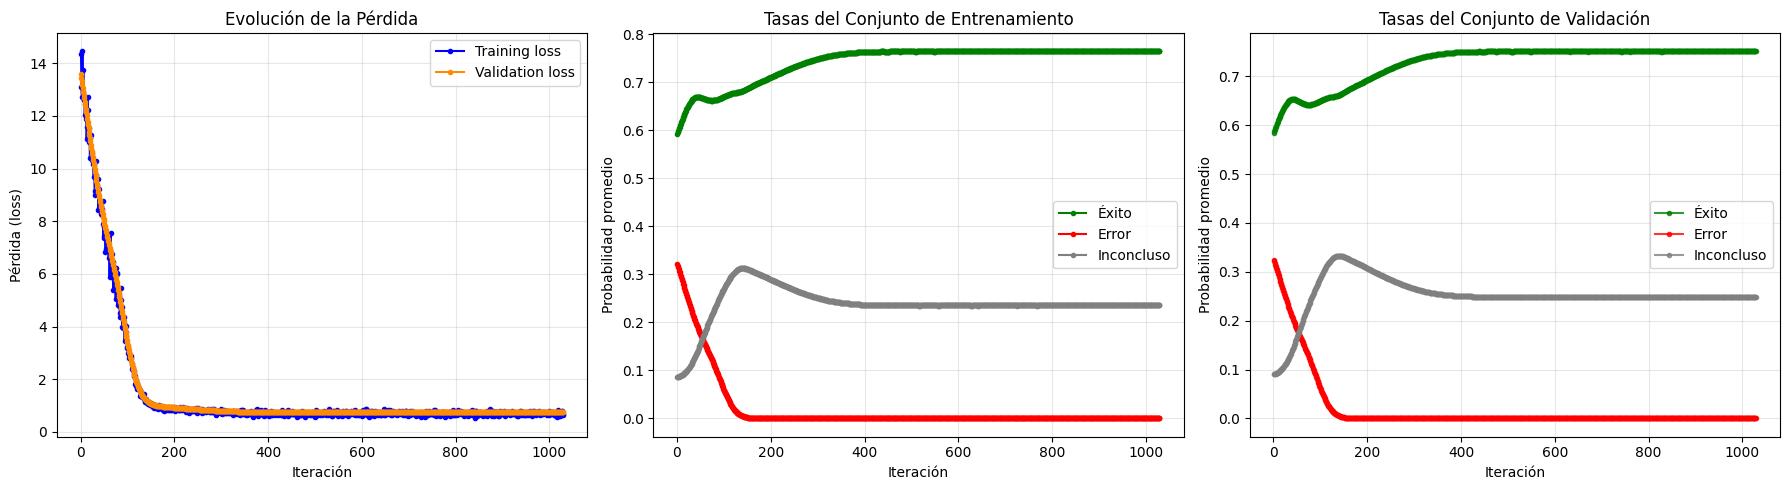

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

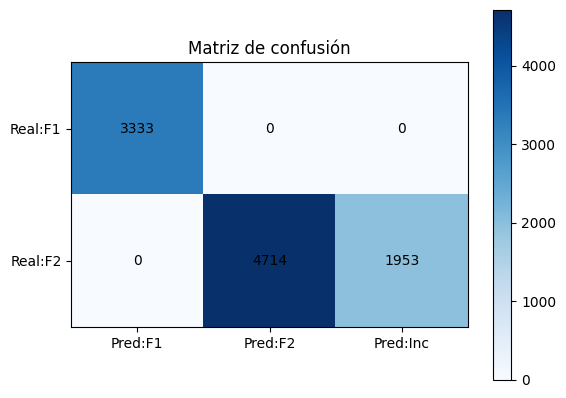

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
